#### import dependencies

In [1]:
import numpy as np
from libpysal.weights import lat2W, Kernel
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
import libpysal as ps  # Ensure PySAL is installed
from libpysal.weights import DistanceBand, lat2W, Kernel
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
from scipy.stats import pearsonr

from numpy.linalg import inv

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Define autocorrelation function. 

def draw_map(N, lamb, W):
    """
    N    = number of areal units
    lamb = spatial autocorrelation parameter
    W    = spatial weights matrix
    """

    W.transform = "r"
    e = np.random.random((N, 1))
    u = inv(np.eye(N) - lamb * W.full()[0])
    u = np.dot(u, e)
    u = (u - u.mean()) / np.std(u)
    return u

# Define function to create tract polygons over the area
def create_tracts(xmin, xmax, ymin, ymax, x_step, y_step):
    polys = []
    ids = []
    id_counter = 0
    for x0 in np.arange(xmin, xmax, x_step):
        for y0 in np.arange(ymin, ymax, y_step):
            x1 = x0 + x_step
            y1 = y0 + y_step
            poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            polys.append(poly)
            ids.append(id_counter)
            id_counter += 1
    gdf = gpd.GeoDataFrame({'tract_id': ids, 'geometry': polys})
    return gdf

# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step) # this is important as its used in 16x16 visualiation

-  Simulation of X
    - In this current experiment:
      - rho = 0.80
      - Total of 3600 points with 2000 clustered and 1600 background points.
      - Number of clusters = 15

In [3]:
def simulate_clustered_S1(num_points, background_points, num_clusters, grid_gdf, cluster_std=50, random_state=None):
   
    if random_state is not None:
        np.random.seed(random_state)

    x_range = (grid_gdf.total_bounds[0], grid_gdf.total_bounds[2])
    y_range = (grid_gdf.total_bounds[1], grid_gdf.total_bounds[3])

    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    clustered_locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)

    # Clip points to stay within the study area
    clustered_locations[:, 0] = np.clip(clustered_locations[:, 0], x_range[0], x_range[1])
    clustered_locations[:, 1] = np.clip(clustered_locations[:, 1], y_range[0], y_range[1])

    background_locations = np.random.uniform(low=[x_range[0], y_range[0]],
                                             high=[x_range[1], y_range[1]],
                                             size=(background_points, 2))

    # Step 4: Combine All Points
    all_locations = np.vstack((clustered_locations, background_locations))

    ## Generate data
    Nlat = 48
    N = Nlat**2
    D = 2
    M = 3
    W = lat2W(Nlat, Nlat, rook=True)

    rawX1 = draw_map(N, .65, W).flatten()

    # newX = (rawX1-rawX1.min()) / (rawX1.max()-rawX1.min()) #* (7000 - 250) + 250 
    
    x = all_locations[:, 0]
    y = all_locations[:, 1]
    S1 = []
    cell_size = 600 / Nlat  # 12.5 in this case
    S1 = []
    for i in range(len(all_locations)):
        u = min(int(np.floor(x[i] / cell_size)), Nlat - 1)
        v = min(int(np.floor(y[i] / cell_size)), Nlat - 1)
        S1.append(rawX1[u * Nlat + v])

    return np.array(S1), np.array(all_locations)
                       
# Run Simulation with Ensured Coverage
S1, loc1  = simulate_clustered_S1(num_points=2000, background_points=1600, num_clusters=15, grid_gdf=tracts_gdf48,
                                 cluster_std=25, random_state=27)

S2 = tracts_gdf48
loc2 = np.array([[point.x, point.y] for point in S2.geometry.centroid])

- Visualizing the spatial Distribution of X

- Next, generating the spatially varying coefficient surface (beta)

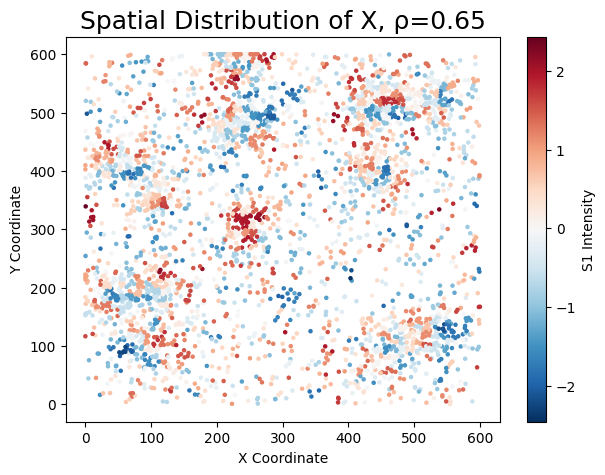

In [4]:
plt.figure(figsize=(7, 5))
# tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" 
cmap = plt.cm.RdBu_r

# Scatter plot with diverging colormap
sc = plt.scatter(loc1[:, 0], loc1[:, 1], c=S1, cmap=cmap, edgecolor="face", s=5)

# Add Colorbar
plt.colorbar(sc, label="S1 Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial Distribution of X, ρ=0.65", fontsize=18)

plt.show()

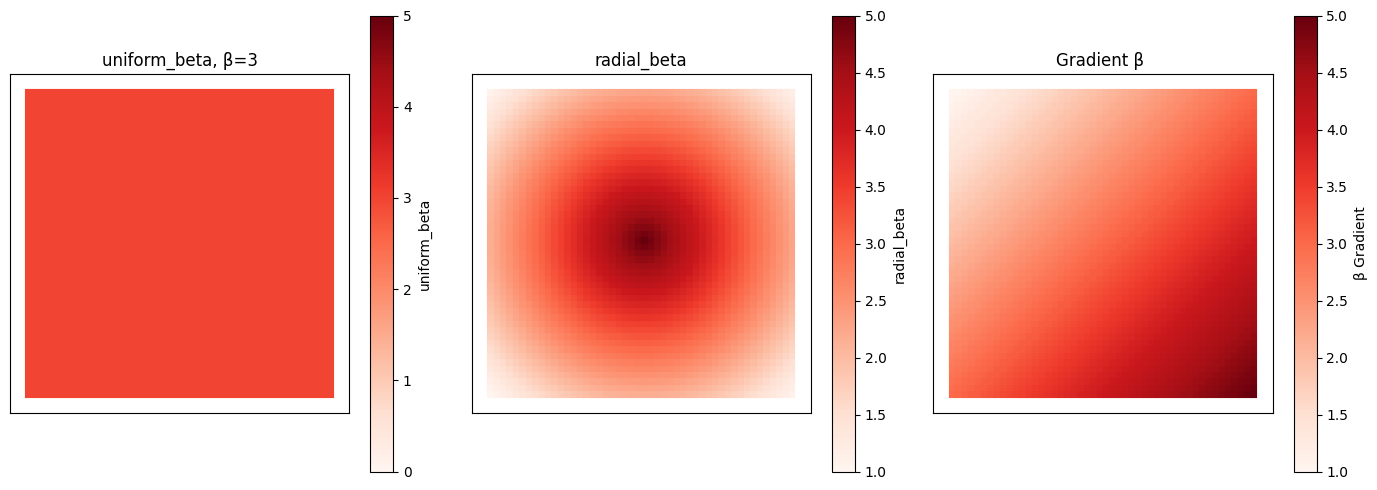

In [5]:
def uniform(Nlat, value=3):
 
    return np.full((Nlat**2, 1), value)

uniform_beta = uniform(48)

def radial(Nlat, center_value=4, edge_value=1):
    grid = np.zeros((Nlat, Nlat))
    cx, cy = Nlat / 2, Nlat / 2
    max_dist = np.sqrt((cx)**2 + (cy)**2)

    for i in range(Nlat):
        for j in range(Nlat):
            dist = np.sqrt((i - cx)**2 + (j - cy)**2)
            weight = 1 - (dist / max_dist)  # normalized to [0, 1]
            grid[i, j] = edge_value + (center_value - edge_value) * weight

    return grid.flatten().reshape(-1, 1)

radial_beta = radial(48)

def gradient(Nlat, min_val=0, max_val=5):

    # Create row (Y) and column (X) indices
    rows, cols = np.meshgrid(np.arange(Nlat), np.arange(Nlat), indexing='ij')
    
    # Normalize and invert diagonal direction
    diag_gradient = (rows + (Nlat - 1 - cols)) / (2 * (Nlat - 1))  # NE to SW
    
    # Rescale to desired range
    beta_vals = min_val + (max_val - min_val) * diag_gradient
    return beta_vals.reshape(-1, 1)

gradient_beta = gradient(48)

tracts_gdf48['uniform_beta'] = uniform_beta
tracts_gdf48['radial_beta'] = radial_beta
tracts_gdf48['gradient_beta'] = gradient_beta


# --- Plot ---
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
cmap = plt.cm.RdBu_r

# uniform beta
norm_x = mcolors.Normalize(vmin=0, vmax=5)
tracts_gdf48.plot(column='uniform_beta', cmap=plt.cm.Reds, linewidth=0.1, edgecolor='face', ax=ax[0], vmin=0, vmax=5)
sm_x = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm_x)
sm_x._A = []
fig.colorbar(sm_x, ax=ax[0]).set_label('uniform_beta')
ax[0].set_title('uniform_beta, β=3')

# radial beta
norm_const = mcolors.Normalize(vmin=1.0, vmax=5.0)
tracts_gdf48.plot(column='radial_beta', cmap=plt.cm.Reds, linewidth=0.1, edgecolor='face', ax=ax[1])
sm_const = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm_const)
sm_const._A = []
fig.colorbar(sm_const, ax=ax[1]).set_label('radial_beta')
ax[1].set_title('radial_beta')

# gradient beta
norm_grad = mcolors.Normalize(vmin=1.0, vmax=5.0)
tracts_gdf48.plot(column='gradient_beta', cmap=plt.cm.Reds, linewidth=0.1, edgecolor='face', ax=ax[2])
sm_grad = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm_grad)
sm_grad._A = []
fig.colorbar(sm_grad, ax=ax[2]).set_label('β Gradient')
ax[2].set_title('Gradient β ')

# Final layout
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show()


In [6]:
# def low_SH_beta(Nlat):
#     """
#     Create a smooth gradient surface on an Nlat×Nlat grid
#     that increases from the northwest corner (0) to the 
#     southeast corner (1), returned as a flat (Nlat^2, 1) array.
#     """
#     # 1. create normalized coordinates 0→1
#     x = np.linspace(0, 1, Nlat)
#     y = np.linspace(0, 1, Nlat)
#     xv, yv = np.meshgrid(x, y)
    
#     # 2. build NW→SE gradient (no rescaling)
#     grad = (xv + yv) / 2.0
    
#     # 3. return as column vector
#     return grad.reshape(-1, 1)


# low = low_SH_beta(48)

# low_scaled =  2 * (low - low.min()) / (low.max() - low.min()) - 1

# plt.figure(figsize=(10, 8))
# tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# # Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
# cmap = plt.cm.RdBu_r

# # # Scatter plot with diverging colormap
# sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=low_scaled, cmap=cmap, edgecolor=None)

# # Add Colorbar
# plt.colorbar(sc, label="y Intensity")

# # Labels and Title
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.title("Spatially varying β - Low S.H", fontsize=18)

# plt.show()

In [7]:
# ## Generate beta
# Nlat = 48
# N = Nlat**2

# W = lat2W(Nlat, Nlat, rook=True)

# np.random.seed(2025)
# beta_surface = draw_map(N, 0.98, W)

# beta_surface_scaled = 2 * (beta_surface - beta_surface.min()) / (beta_surface.max() - beta_surface.min()) - 1

# plt.figure(figsize=(10, 8))
# tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# # Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
# cmap = plt.cm.RdBu_r

# # # Scatter plot with diverging colormap
# sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=beta_surface_scaled, cmap=cmap, edgecolor=None)

# # Add Colorbar
# plt.colorbar(sc, label="y Intensity")

# # Labels and Title
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.title("Spatially varying β", fontsize=18)

# plt.show()

##### To generate the y, in the notebook we are setting the value of k (which determines the number of nearest neighbors of y in X to smooth from) to 2, 25, 250, and 500. Starting from k=2

## K = 2

- Generate the y

- Visualize the spatial distribution of smoothed X with k neighbors

- Visualized the spatial distribution of y 

In [8]:
# B = radial_beta.flatten()
B = uniform_beta.flatten()
# B = gradient_beta.flatten()

k_smooth = 80

nbrs_S2 = NearestNeighbors(n_neighbors=k_smooth).fit(loc1)

smoothed_S1_to_S2 = np.zeros(len(S2))

for i in range(len(S2)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc2[i]])
    smoothed_S1_to_S2[i] = np.mean(S1[indices_S1_to_S2[0]].flatten())

np.random.seed(26)

# Sanity check:
print("Variation in smoothed_X:", smoothed_S1_to_S2.max() - smoothed_S1_to_S2.min())

error_term = np.random.normal(0, 0.75, len(S2))

y_orig = B * smoothed_S1_to_S2 + error_term

Variation in smoothed_X: 2.5091954760457114


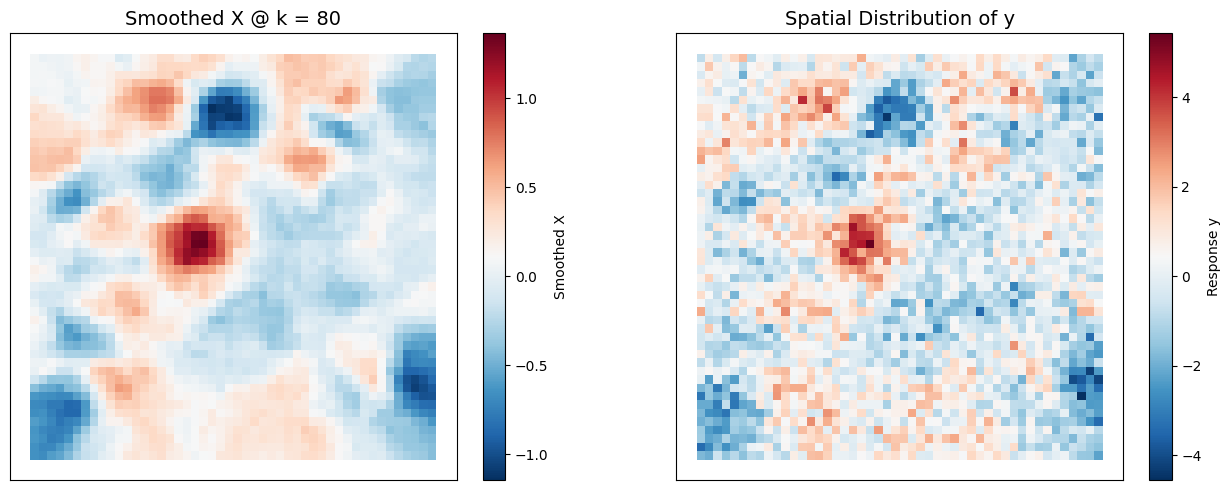

In [9]:
# Assign smoothed values and y to geodataframe
tracts_gdf48['sX'] = smoothed_S1_to_S2
tracts_gdf48['y'] = y_orig

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# === Plot 1: smoothed X ===
norm_sx = mcolors.Normalize(vmin=tracts_gdf48["sX"].min(), vmax=tracts_gdf48["sX"].max())
tracts_gdf48.plot(
    column="sX",
    cmap=plt.cm.RdBu_r,
    edgecolor="face",
    linewidth=0,
    legend=False,
    ax=ax[0]
)
sm1 = cm.ScalarMappable(norm=norm_sx, cmap=plt.cm.RdBu_r)
sm1._A = []
cbar1 = fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)
cbar1.set_label("Smoothed X")
ax[0].set_title(f"Smoothed X @ k = {k_smooth}", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# === Plot 2: y ===
norm_y = mcolors.Normalize(vmin=tracts_gdf48["y"].min(), vmax=tracts_gdf48["y"].max())
tracts_gdf48.plot(
    column="y",
    cmap=plt.cm.RdBu_r,
    edgecolor="face",
    linewidth=0,
    legend=False,
    ax=ax[1]
)
sm2 = cm.ScalarMappable(norm=norm_y, cmap=plt.cm.RdBu_r)
sm2._A = []
cbar2 = fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)
cbar2.set_label("Response y")
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
plt.show()

##### Run GLASS at different values of K to test its sensitivity

- Visualize the metrics at the different K. R2, SRMSE, AICc

In [10]:
r2_list = []
srmse_list = []
bw_list = []
aicc_list = []

part1 = list(range(2, 11, 1))
part2 = list(range(10, 101, 5))
part3 = list(range(100, 500, 25))
part4 = [1250, 1500, 1750, 2000, 2250]

## Combine all parts
k_values = part1 + part2 #+ part3 + part4

# k_values = [1250, 1500, 1750, 2000, 2250]

for k in k_values:
    # --- 1. Smooth point-level X (S1) to polygon-level (S2 centroids) ---
    nbrs_S1 = NearestNeighbors(n_neighbors=k).fit(loc1)  # loc1 = point locations
    smoothed_S1_to_S2 = np.zeros(len(loc2))  # loc2 = tract centroids
    
    for i in range(len(loc2)):
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])
        bw_S1 = distances_S1_to_S2[0][-1]
        
        # Apply Gaussian kernel function
        weights_X = np.exp(-0.5 * (distances_S1_to_S2[0] / bw_S1) ** 2)

        local_X = S1[indices_S1_to_S2[0]]  # S1 = point-level X
        smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)

        # local_X = S1[indices_S1_to_S2[0]]  # Use S1 as the independent variable
        # smoothed_S1_to_S2[i] = local_X.mean()
    
    # --- 3. Fit GWR at polygon level ---
    coords = loc2  # tract centroids
    X_design = smoothed_S1_to_S2.reshape(-1,1)
    y_design = y_orig.reshape(-1,1)
    
    bw = Sel_BW(coords, y_design, X_design, constant=False).search(bw_min=2)
    gwr_model = GWR(coords, y_design, X_design, bw, constant=False)
    gwr_results = gwr_model.fit()
    
    # --- 4. Extract metrics ---
    y_pred = gwr_results.predy.flatten()
    r2 = r2_score(y_orig, y_pred)
    srmse = np.sqrt(mean_squared_error(y_orig, y_pred)) / np.std(y_orig)
    aicc = gwr_results.aicc
    
    r2_list.append(r2)
    srmse_list.append(srmse)
    bw_list.append(bw)
    aicc_list.append(aicc)
    
    print(f"k={k}: R2={r2:.4f}, SRMSE={srmse:.4f}, AICc={aicc:.4f}, BW={bw:.4f}")

k=2: R2=0.2883, SRMSE=0.8436, AICc=7099.0230, BW=46.0000
k=3: R2=0.3236, SRMSE=0.8224, AICc=7037.0613, BW=38.0000
k=4: R2=0.3689, SRMSE=0.7944, AICc=6966.5672, BW=30.0000
k=5: R2=0.3773, SRMSE=0.7891, AICc=6928.9745, BW=30.0000
k=6: R2=0.3965, SRMSE=0.7769, AICc=6852.6831, BW=30.0000
k=7: R2=0.4244, SRMSE=0.7587, AICc=6790.5188, BW=26.0000
k=8: R2=0.4451, SRMSE=0.7449, AICc=6747.0828, BW=24.0000
k=9: R2=0.4583, SRMSE=0.7360, AICc=6686.4648, BW=24.0000
k=10: R2=0.4660, SRMSE=0.7308, AICc=6651.7106, BW=24.0000
k=10: R2=0.4660, SRMSE=0.7308, AICc=6651.7106, BW=24.0000
k=15: R2=0.5075, SRMSE=0.7018, AICc=6461.0034, BW=24.0000
k=20: R2=0.5330, SRMSE=0.6834, AICc=6347.3902, BW=22.0000
k=25: R2=0.5471, SRMSE=0.6730, AICc=6267.5429, BW=22.0000
k=30: R2=0.5602, SRMSE=0.6632, AICc=6143.3448, BW=26.0000
k=35: R2=0.5943, SRMSE=0.6369, AICc=6020.5458, BW=22.0000
k=40: R2=0.6050, SRMSE=0.6285, AICc=5902.1951, BW=26.0000
k=45: R2=0.6158, SRMSE=0.6199, AICc=5786.3200, BW=30.0000
k=50: R2=0.6177, SRMSE

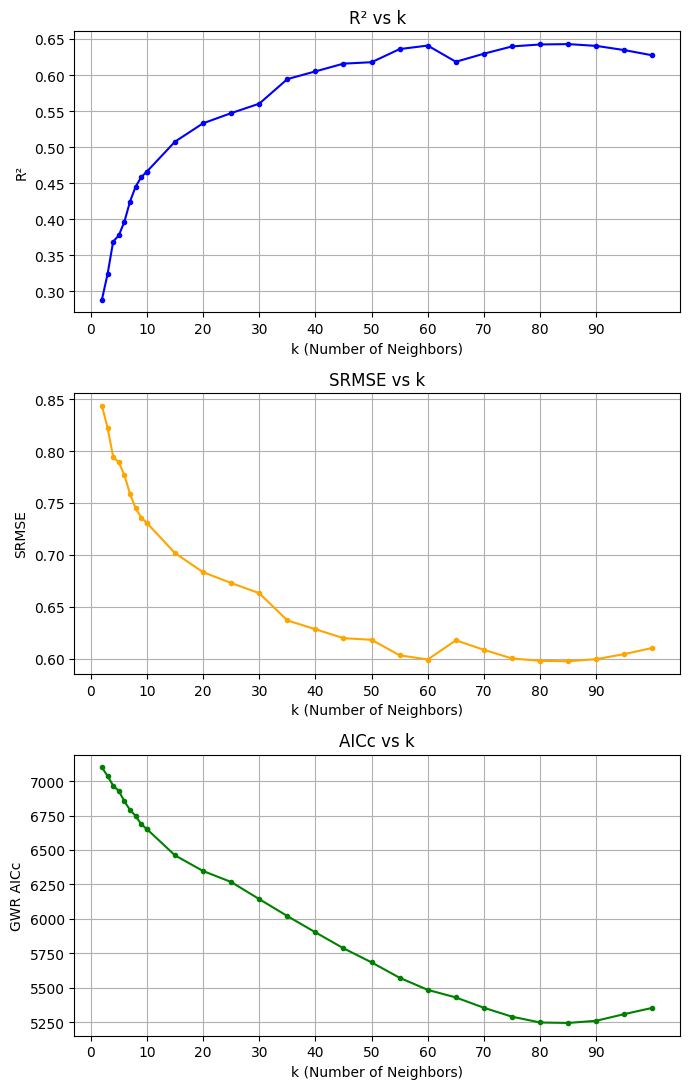

In [11]:
plt.figure(figsize=(7, 11))

# Plot R²
plt.subplot(3, 1, 1)
plt.plot(k_values, r2_list, color='blue', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R²')
plt.title('R² vs k')
plt.grid()
plt.xticks(np.arange(min(k_values)-2, max(k_values), 10),)

# Plot SRMSE
plt.subplot(3,1, 2)
plt.plot(k_values, srmse_list, color='orange', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('SRMSE')
plt.title('SRMSE vs k')
plt.grid()
plt.xticks(np.arange(min(k_values)-2, max(k_values), 10), )


# Plot AIcc
plt.subplot(3,1, 3)
plt.plot(k_values, aicc_list, color='green', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('GWR AICc')
plt.title('AICc vs k')
plt.grid()
plt.xticks(np.arange(min(k_values)-2, max(k_values), 10), )

plt.tight_layout()
plt.show()

- GLASS Algorithm (commented out)

- Visualization of recovered betas by GLASS (commented out)

In [12]:
nbrs_S1 = NearestNeighbors(n_neighbors=k_smooth).fit(loc1)  # Neighbors from S1 (points)
N = 48*48
smoothed_S1_to_S2 = np.zeros(N)

# Step 1: Smoothing X values (S1) to areal units (S2)
for i in range(N):
    # Find nearest S1 points for each S2 centroid
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])
    bw_S1 = distances_S1_to_S2[0][-1]
    
    # Apply Gaussian kernel function
    weights_X = np.exp(-0.5 * (distances_S1_to_S2[0] / bw_S1) ** 2)

    local_X = S1[indices_S1_to_S2[0]]  # S1 = point-level X
    smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)
    
    # local_X = S1[indices_S1_to_S2[0]]  # Use S1 as the independent variable
    # smoothed_S1_to_S2[i] = local_X.mean()

# calibrate GWR analysis
gwr_X  = smoothed_S1_to_S2.reshape(-1,1)
gwr_y = y_orig.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in S2['geometry'].centroid])
gwr_X.shape, gwr_y.shape

gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw, constant=False).fit()
print(gwr_bw)

params48_glass = gwr_results.params
y_pred_glass = gwr_results.predy
aicc_glass = gwr_results.aicc

print(gwr_results.aicc), print(gwr_results.R2);

## calculating the standardized root mean squared error
y_true = y_orig.reshape(-1,1)
rmse  = np.sqrt(np.mean((y_true - y_pred_glass)**2))
std_dev = np.std(y_true)
srmse = rmse / std_dev
srmse, rmse

pd.DataFrame({'BW': gwr_bw, 'R2':gwr_results.R2, 'SRMSE': srmse}, index=['GLASS Results']).T

2303.0
5247.745248227371
0.6423804915907255


GLASS Results
BW       2303.000000
R2          0.642380
SRMSE       0.598013

<Figure size 1000x800 with 0 Axes>

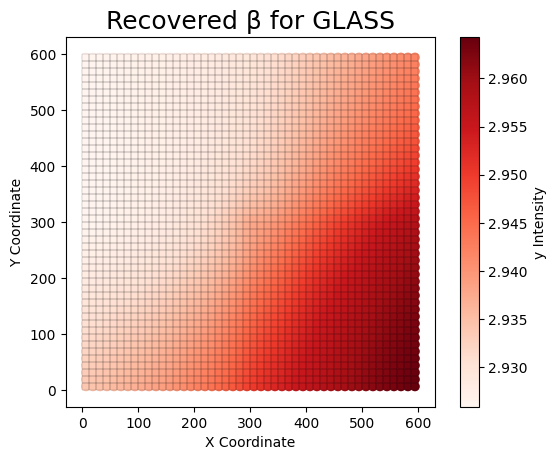

In [13]:
plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

cmap = plt.cm.Reds

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=params48_glass.flatten(), cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Recovered β for GLASS", fontsize=18)

plt.show()

### Aggregations

#### 48x48

- Create a geodataframe for X

- sjoin X points to 48x48 polygon tracts 

- Aggregate up to 48x48

- Check for and remove missing values

- Preprocess data for GWR model, X is aggregated up to 48x48, y & B are already at 48x48

- Compute GWR model metrics, R2, AICc, SRMSE

In [14]:
# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

In [15]:
S1_gdf = gpd.GeoDataFrame({'X': S1, 'geometry': gpd.points_from_xy(loc1[:, 0], loc1[:, 1])})

In [16]:
# Spatial join: assign S1 points to 48x48 tracts
S1_agg = gpd.sjoin(S1_gdf, tracts_gdf48, how="left", predicate="within")

In [17]:
S1_agg = S1_agg.groupby("tract_id")["X"].mean().reset_index()
X_48x48 = tracts_gdf48.merge(S1_agg, on="tract_id", how="left")
X_48x48['y'] = y_orig

In [18]:
sX1_48 = X_48x48.copy()
sX1_48.isna().sum()

tract_id      0
geometry      0
X           806
y             0
dtype: int64

In [19]:
sX1_48.dropna(inplace=True)
sX1_48.isna().sum()

tract_id    0
geometry    0
X           0
y           0
dtype: int64

In [20]:
gwr_X  = sX1_48['X'].values.reshape(-1,1)
gwr_y = sX1_48['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_48['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((1498, 1), (1498, 1))

In [21]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw48 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw48, constant=False).fit()
print(gwr_bw48)

50.0


In [22]:
params48 = gwr_results.params
y_pred48 = gwr_results.predy
aicc_gwr48 = gwr_results.aicc
r2_48 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

4755.397196525568
0.2738875037665516


In [23]:
## calculating the standardized root mean squared error
y_true48 = sX1_48['y'].values.reshape(-1,1)
rmse48  = np.sqrt(np.mean((y_true48 - y_pred48)**2))
std_dev48 = np.std(y_true48)
srmse48 = rmse48 / std_dev48
srmse48, rmse48

(np.float64(0.8521223481598451), np.float64(1.1137094253253923))

#### 24x24

- Resize the tracts from 48x48 to 24x24 by adjusting the stepsize

- Sjoin X points to 24x24 polygon tracts 

- Aggregate X up to 24x24

- Also aggregate y up to 24x24

- Check for and remove missing values

- Preprocess data for GWR model

- Compute GWR model metrics, R2, AICc, SRMSE

In [24]:
x_step, y_step = 25, 25 # Creates a 24x24 grid, resulting in 576 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_24 = np.array([[point.x, point.y] for point in tracts_gdf24.geometry.centroid])

In [25]:
# X_48x48['geometry'] = X_48x48.geometry.centroid

In [26]:
# Spatial join X to 24x24 tracts
spj24_X = gpd.sjoin(S1_gdf, tracts_gdf24, how='right', predicate='within')
agg_24_X = spj24_X.groupby('tract_id')[['X']].mean().reset_index()

In [27]:
# Spatial join y @ 48x48 to 24x24 tracts. Extract only the y from the df: line 2. 
spj24_y = gpd.sjoin(X_48x48, tracts_gdf24, how='right', predicate='within')
agg_24_y = spj24_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [28]:
agg_24 = agg_24_X.merge(agg_24_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [29]:
# Aggregate X & Y within each 24x24 grid cell
GWR_24x24_gdf = tracts_gdf24.merge(agg_24, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [30]:
sX1_24 = GWR_24x24_gdf.copy()
sX1_24.isna().sum()

tract_id           0
geometry           0
X                 23
tract_id_right     0
y                  0
dtype: int64

In [31]:
sX1_24.dropna(inplace=True)
sX1_24.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [32]:
gwr_X  = sX1_24['X'].values.reshape(-1,1)
gwr_y = sX1_24['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_24['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((553, 1), (553, 1))

In [33]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw24 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw24, constant=False).fit()
print(gwr_bw24)

35.0


In [34]:
params24 = gwr_results.params
y_pred24 = gwr_results.predy
aicc_gwr24 = gwr_results.aicc
r2_24 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

1509.68153869242
0.3394363289064902


In [35]:
## calculating the standardized root mean squared error
y_true24 = sX1_24['y'].values.reshape(-1,1)
rmse24  = np.sqrt(np.mean((y_true24 - y_pred24)**2))
std_dev24 = np.std(y_true24)
srmse24 = rmse24 / std_dev24
srmse24, rmse24

(np.float64(0.8127506820012579), np.float64(0.8641918277393666))

#### 16x16

- Resize the tracts from 48x48 to 16x16 by adjusting the stepsize

- Sjoin X points to 16x16 polygon tracts 

- Aggregate X up to 16x16

- Also aggregate y up to 16x16

- Check for and remove missing values

- Preprocess data for GWR model

- Compute GWR model metrics, R2, AICc, SRMSE

In [36]:
x_step, y_step = 37.5, 37.5 # Creates a 32x32 grid, resulting in 576 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_16 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])

In [37]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [38]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [39]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [40]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [41]:
# Aggregate X & y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [42]:
sX1_16 = GWR_16x16_gdf.copy()

gwr_X  = sX1_16['X'].values.reshape(-1,1)
gwr_y = sX1_16['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_16['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [43]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw16 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw16, constant=False).fit()
print(gwr_bw16)

41.0


In [44]:
params16 = gwr_results.params
y_pred16 = gwr_results.predy
aicc_gwr16 = gwr_results.aicc
r2_16 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

656.0909547875585
0.32229193902556863


In [45]:
## calculating the standardized root mean squared error
y_true16 = sX1_16['y'].values.reshape(-1,1)
rmse16  = np.sqrt(np.mean((y_true16 - y_pred16)**2))
std_dev16 = np.std(y_true16)
srmse16 = rmse16 / std_dev16
srmse16, rmse16

(np.float64(0.8232302599968198), np.float64(0.8105916383810156))

#### 12x12

- Resize the tracts from 48x48 to 12x12 by adjusting the stepsize

- Sjoin X points to 12x12 polygon tracts 

- Aggregate X up to 12x12

- Also aggregate y up to 12x12

- Check for and remove missing values

- Preprocess data for GWR model

- Compute GWR model metrics, R2, AICc, SRMSE

In [46]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 50, 50  # Creates a 12x12 grid, resulting in 144 tracts cell divisions
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_12 = np.array([[point.x, point.y] for point in tracts_gdf12.geometry.centroid])

In [47]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [48]:
# Spatial join X to 12x12 tracts 
spj12_X = gpd.sjoin(S1_gdf, tracts_gdf12, how='right', predicate='within')
agg_12_X = spj12_X.groupby('tract_id')[['X']].mean().reset_index()

In [49]:
# Spatial join y @ 48x48 to 12x12 tracts. Extract only the y from the df: line 2. 
spj12_y = gpd.sjoin(X_48x48, tracts_gdf12, how='right', predicate='within')
agg_12_y = spj12_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [50]:
agg_12 = agg_12_X.merge(agg_12_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [51]:
# Aggregate X & Y within each 24x24 grid cell
GWR_12x12_gdf = tracts_gdf12.merge(agg_12, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [52]:
sX1_12 = GWR_12x12_gdf.copy()
sX1_12.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [53]:
gwr_X  = sX1_12['X'].values.reshape(-1,1)
gwr_y = sX1_12['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_12['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((144, 1), (144, 1))

In [54]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw12 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw12, constant=False).fit()
print(gwr_bw12)

49.0


In [55]:
params12 = gwr_results.params
y_pred12 = gwr_results.predy
aicc_gwr12 = gwr_results.aicc
r2_12 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

338.1074694973241
0.37010755571991116


In [56]:
## calculating the standardized root mean squared error
y_true12 = sX1_12['y'].values.reshape(-1,1)
rmse12  = np.sqrt(np.mean((y_true12 - y_pred12)**2))
std_dev12 = np.std(y_true12)
srmse12 = rmse12 / std_dev12
srmse12, rmse12

(np.float64(0.7936576366923517), np.float64(0.7353169887367121))

#### 8x8

- Resize the tracts from 48x48 to 8x8 by adjusting the stepsize

- Sjoin X points to 8x8 polygon tracts 

- Aggregate X up to 8x8

- Also aggregate y up to 8x8

- Check for and remove missing values

- Preprocess data for GWR model

- Compute GWR model metrics, R2, AICc, SRMSE

In [57]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 8x8 grid, resulting in 256 tracts cell divisions
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_8 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])

In [58]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [59]:
# Spatial join X to 8x8 tracts 
spj8_X = gpd.sjoin(S1_gdf, tracts_gdf8, how='right', predicate='within')
agg_8_X = spj8_X.groupby('tract_id')[['X']].mean().reset_index()

In [60]:
# Spatial join y @ 48x48 to 8x8 tracts. Extract only the y from the df: line 2. 
spj8_y = gpd.sjoin(X_48x48, tracts_gdf8, how='right', predicate='within')
agg_8_y = spj8_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [61]:
agg_8 = agg_8_X.merge(agg_8_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [62]:
# Aggregate X & Y within each 24x24 grid cell
GWR_8x8_gdf = tracts_gdf8.merge(agg_8, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [63]:
sX1_8 = GWR_8x8_gdf.copy()
sX1_8.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [64]:
gwr_X  = sX1_8['X'].values.reshape(-1,1)
gwr_y = sX1_8['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_8['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [65]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw8 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw8, constant=False).fit()
print(gwr_bw8)

22.0


In [66]:
params8 = gwr_results.params
y_pred8 = gwr_results.predy
aicc_gwr8 = gwr_results.aicc
r2_8 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

111.67885152842862
0.6232756135285538


In [67]:
## calculating the standardized root mean squared error
y_true8 = sX1_8['y'].values.reshape(-1,1)
rmse8  = np.sqrt(np.mean((y_true8 - y_pred8)**2))
std_dev8 = np.std(y_true8)
srmse8 = rmse8 / std_dev8
srmse8, rmse8

(np.float64(0.6137787764915354), np.float64(0.5017474571451774))

#### table

In [68]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [69]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [70]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [71]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24    16x16    12x12      8x8
BW         50.0000  35.0000  41.0000  49.0000  22.0000
R²          0.2739   0.3394   0.3223   0.3701   0.6233
SRMSE       0.8521   0.8128   0.8232   0.7937   0.6138

#### Visualizations

##### 48x48

In [72]:
loc2_48 = np.array([[point.x, point.y] for point in sX1_48.geometry.centroid])

In [73]:
sX1_48['params48'] = params48
sX1_48

tracts_gdf48_points = tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj48_48 = gpd.sjoin(tracts_gdf48_points, sX1_48, how='left', predicate='within')
spj48_48['y'] = y_orig

tracts_gdf48["X_48x48"] = spj48_48["X"]
tracts_gdf48['y_48x48'] = spj48_48["y"]
tracts_gdf48['est_beta48'] = spj48_48["params48"]


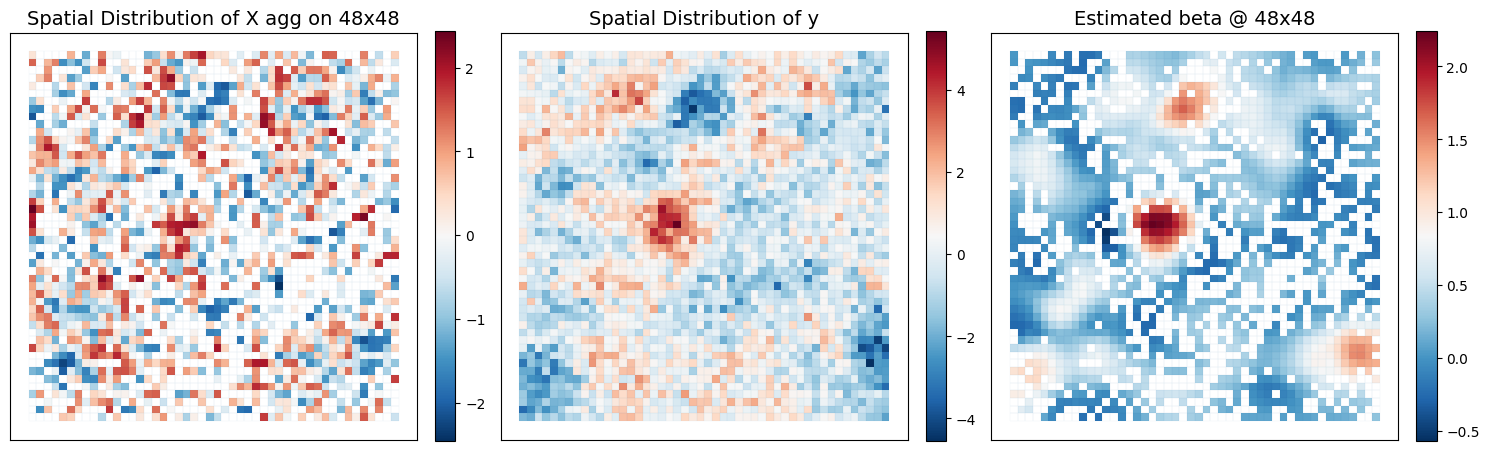

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 48x48", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta48", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 48x48", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 24x24

In [75]:
sX1_24['params24'] = params24
sX1_24

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj24_48 = gpd.sjoin(tracts_gdf48_points, sX1_24, how='left', predicate='within')

In [76]:
tracts_gdf48["X_24x24"] = spj24_48["X"]
tracts_gdf48['y_24x24'] = spj24_48["y"]
tracts_gdf48['est_beta24'] = spj24_48["params24"]

In [77]:
spj24_48["X"]

0      -1.520916
1      -1.520916
2       0.115459
3       0.115459
4            NaN
          ...   
2299   -0.861856
2300    0.454034
2301    0.454034
2302    0.099787
2303    0.099787
Name: X, Length: 2304, dtype: float64

In [78]:
tracts_gdf48['est_beta24'].isna().sum()

np.int64(92)

In [79]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [80]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [81]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [82]:
# Aggregate X & Y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

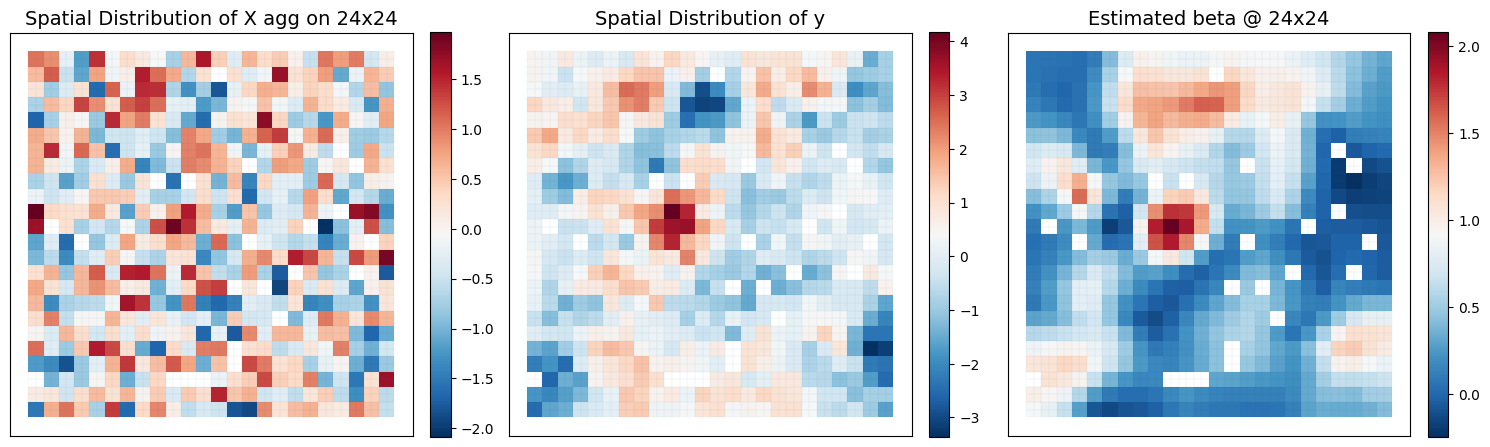

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 24x24", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta24", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 24x24", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 16x16

In [84]:
sX1_16['params16'] = params16
sX1_16

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj16_48 = gpd.sjoin(tracts_gdf48_points, sX1_16, how='left', predicate='within')

In [85]:
tracts_gdf48["X_16x16"] = spj16_48["X"]
tracts_gdf48['y_16x16'] = spj16_48["y"]
tracts_gdf48['est_beta16'] = spj16_48["params16"]

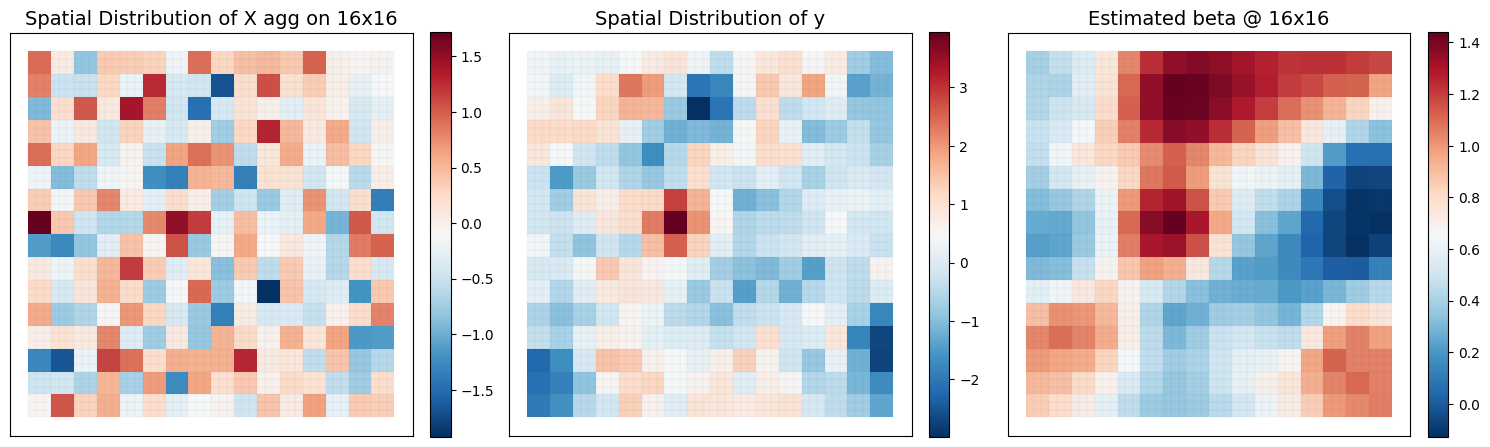

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 16x16", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta16", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 16x16", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 12x12

In [87]:
sX1_12['params12'] = params12
sX1_12

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj12_48 = gpd.sjoin(tracts_gdf48_points, sX1_12, how='left', predicate='within')

In [88]:
tracts_gdf48["X_12x12"] = spj12_48["X"]
tracts_gdf48['y_12x12'] = spj12_48["y"]
tracts_gdf48['est_beta12'] = spj12_48["params12"]

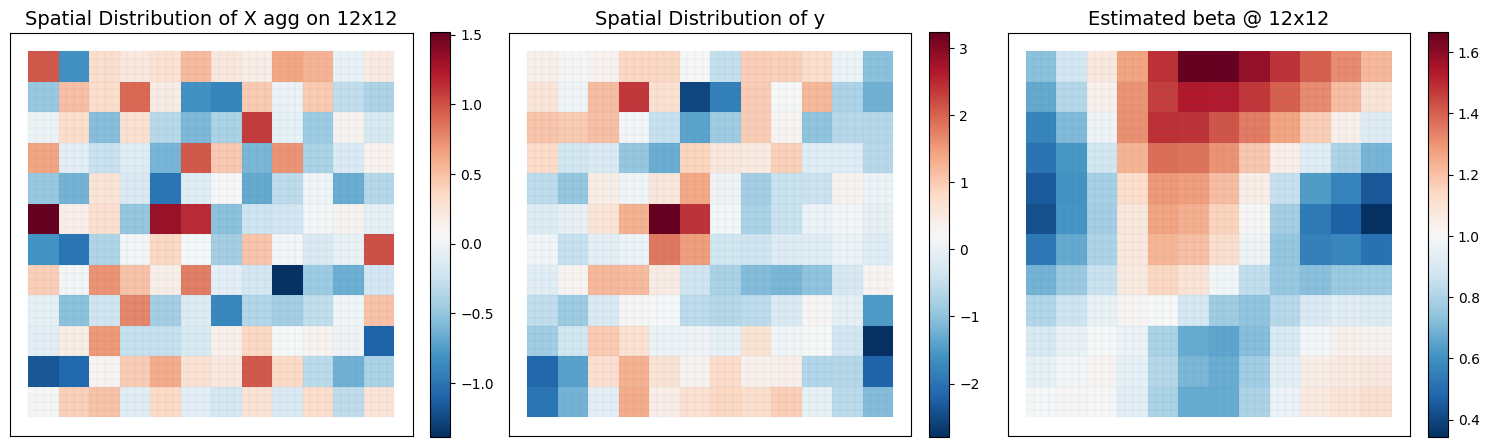

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 12x12", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta12", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 12x12", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 8x8

In [90]:
sX1_8['params8'] = params8

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj8_48 = gpd.sjoin(tracts_gdf48_points, sX1_8, how='left', predicate='within')

In [91]:
tracts_gdf48["X_8x8"] = spj8_48["X"]
tracts_gdf48['y_8x8'] = spj8_48["y"]
tracts_gdf48['est_beta8'] = spj8_48["params8"]

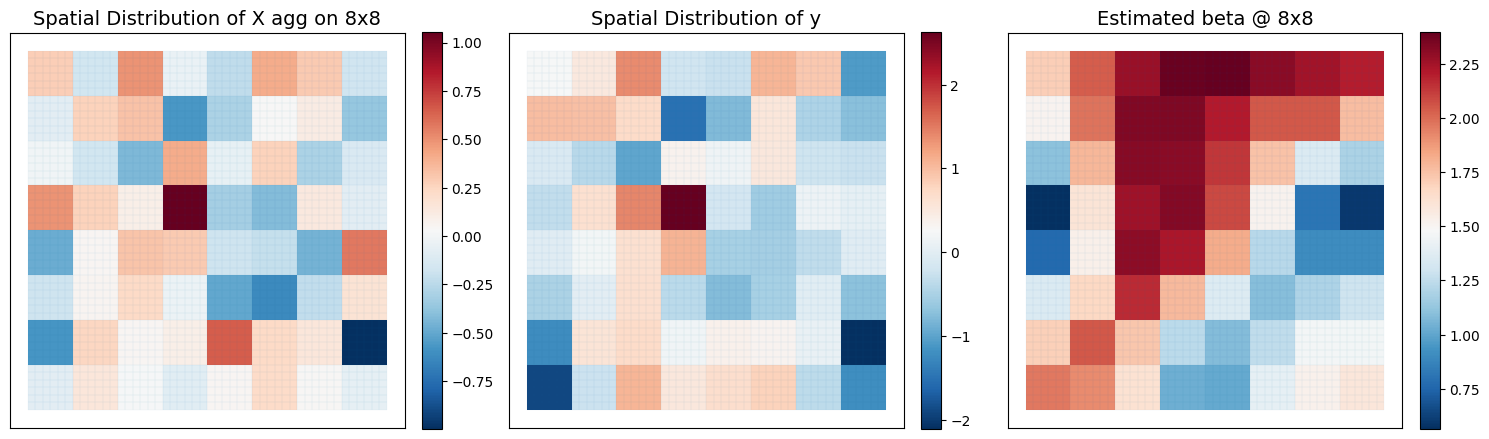

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 8x8", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta8", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 8x8", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [93]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="X_48x48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("X @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="X_24x24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("X @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="X_16x16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("X @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="X_12x12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("X @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="X_8x8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("X @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


In [94]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="y_48x48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("y @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="y_24x24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("y @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="y_16x16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("y @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="y_12x12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("y @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="y_8x8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("y @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


In [95]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="est_beta48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("beta @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="est_beta24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("beta @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="est_beta16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("beta @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="est_beta12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("beta @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="est_beta8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("beta @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


#### General Vizualization

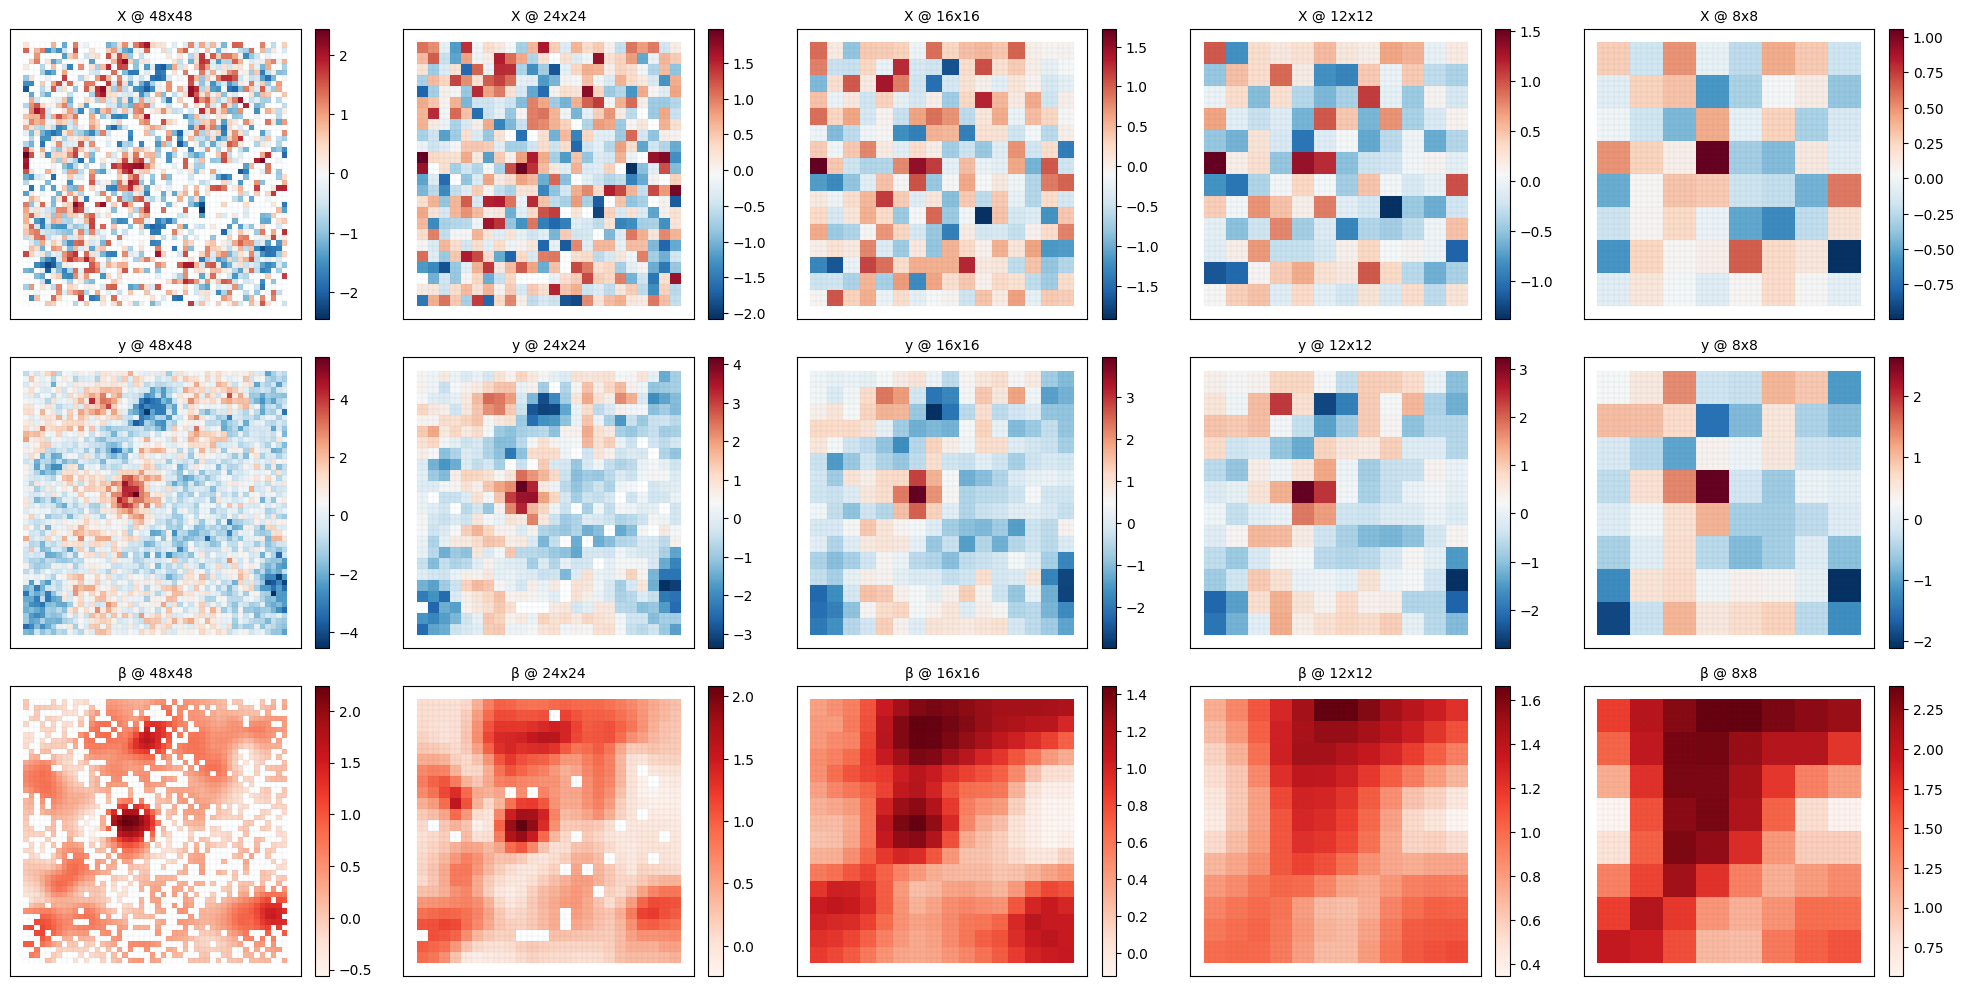

In [96]:
res_labels = ["48x48", "24x24", "16x16", "12x12", "8x8"]
x_cols = ["X_48x48", "X_24x24", "X_16x16", "X_12x12", "X_8x8"]
y_cols = ["y_48x48", "y_24x24", "y_16x16", "y_12x12", "y_8x8"]
beta_cols = ["est_beta48", "est_beta24", "est_beta16", "est_beta12", "est_beta8"]
titles = ["X", "y", "β"]
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r

# Create a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(20, 10))

# Loop through each row (X, y, β) and each column (resolutions)
for row, cols in enumerate([x_cols, y_cols, beta_cols]):
    # Choose colormap based on row index
    cmap = cmap2 if row < 2 else cmap1
    
    for col, colname in enumerate(cols):
        ax = axes[row, col]
        
        # Base map
        tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax)
        
        # Choropleth map
        tracts_gdf48.plot(column=colname, cmap=cmap, edgecolor="face", linewidth=0, ax=ax, legend=False)
        
        # Colorbar normalization
        norm = mcolors.Normalize(vmin=tracts_gdf48[colname].min(), vmax=tracts_gdf48[colname].max())
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        
        # Title and layout
        ax.set_title(f"{titles[row]} @ {res_labels[col]}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

- Rotate the plots

In [97]:
# #### import matplotlib.pyplot as plt
# import numpy as np

# # Parameters
# square_size =1         # 1x1 unit square
# num_points = 2000         # Number of random points

# # Generate random (x, y) points within the square
# x = np.random.uniform(0, square_size, num_points)
# y = np.random.uniform(0, square_size, num_points)

# # Plot
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.set_aspect('equal')

# # Draw the square border
# square = plt.Rectangle((0, 0), square_size, square_size, edgecolor='black', facecolor='none', linewidth=1.5)
# ax.add_patch(square)

# # Scatter the random points
# ax.scatter(x, y, s=10, color='grey')

# # Clean up axes
# ax.set_xlim(0, square_size)
# ax.set_ylim(0, square_size)
# ax.axis('off')

# # plt.title("Random Points Inside a Square")
# plt.show()


In [98]:
# res_labels = ["48x48", "24x24", "16x16", "12x12", "8x8"]
# x_cols = ["X_48x48", "X_24x24", "X_16x16", "X_12x12", "X_8x8"]
# y_cols = ["y_48x48", "y_24x24", "y_16x16", "y_12x12", "y_8x8"]
# beta_cols = ["est_beta48", "est_beta24", "est_beta16", "est_beta12", "est_beta8"]
# titles = ["X", "y", "β"]
# cmap = plt.cm.RdBu_r

# # Create a 5x3 grid (portrait layout)
# fig, axes = plt.subplots(5, 3, figsize=(9, 13))  # Slightly narrower height

# # Plot
# for row, (x_col, y_col, beta_col) in enumerate(zip(x_cols, y_cols, beta_cols)):
#     for col, colname in enumerate([x_col, y_col, beta_col]):
#         ax = axes[row, col]
#         tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax)
#         tracts_gdf48.plot(column=colname, cmap=cmap, edgecolor="face", linewidth=0, ax=ax, legend=False)

#         norm = mcolors.Normalize(vmin=tracts_gdf48[colname].min(), vmax=tracts_gdf48[colname].max())
#         sm = cm.ScalarMappable(cmap=cmap, norm=norm)
#         sm.set_array([])
#         fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.03)

#         if row == 0:
#             ax.set_title(titles[col], fontsize=12)
#         if col == 0:
#             ax.set_ylabel(res_labels[row], fontsize=11)

#         ax.set_xticks([])
#         ax.set_yticks([])

# # Tighten spacing
# plt.tight_layout(h_pad=0.5)  # reduce vertical padding between rows
# # Or fine-tune even more:
# # plt.subplots_adjust(hspace=0.3)

# plt.show()


## K = 25

In [99]:
# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts 
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

In [100]:
B = uniform_beta.flatten()

k_neighbors=25

nbrs_S2 = NearestNeighbors(n_neighbors=k_neighbors).fit(loc1)

smoothed_S1_to_S2 = np.zeros(len(S2))

for i in range(len(S2)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc2[i]])
    smoothed_S1_to_S2[i] = np.mean(S1[indices_S1_to_S2[0]].flatten())


np.random.seed(26)

error_term = np.random.normal(0, 0.1, len(S2))

y_orig = B * smoothed_S1_to_S2 + error_term

<Figure size 1000x800 with 0 Axes>

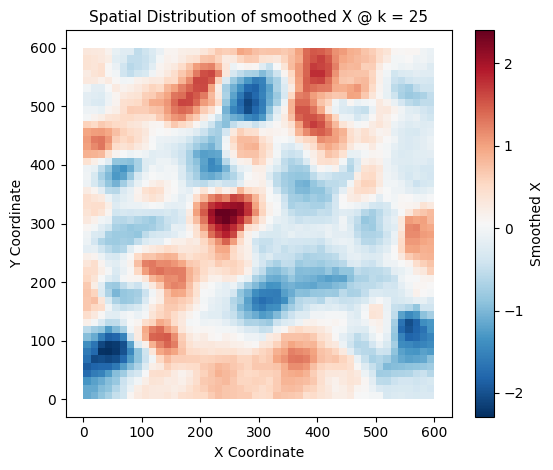

In [101]:
plt.figure(figsize=(10, 8))

# Assign smoothed values
tracts_gdf48['sX'] = smoothed_S1_to_S2

# Plot the choropleth map
ax = tracts_gdf48.plot(
    column="sX",
    cmap=plt.cm.RdBu_r,
    edgecolor="face",
    linewidth=0,
    legend=False
)

# Create scalar mappable for colorbar
norm = mcolors.Normalize(
    vmin=tracts_gdf48["sX"].min(),
    vmax=tracts_gdf48["sX"].max()
)
sm = cm.ScalarMappable(norm=norm, cmap=plt.cm.RdBu_r)
sm._A = []  # workaround to enable colorbar for ScalarMappable

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Smoothed X")

# Add labels and title
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Spatial Distribution of smoothed X @ k = 25", fontsize=11)

plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

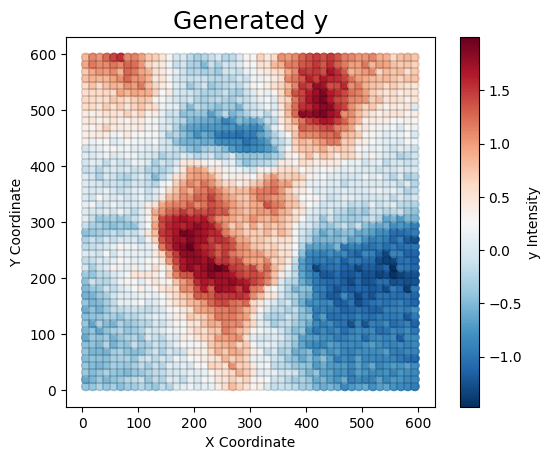

In [372]:
plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
cmap = plt.cm.RdBu_r

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=y_orig, cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Generated y", fontsize=18)

plt.show()

In [103]:
r2_list = []
srmse_list = []
bw_list = []
aicc_list = []

part1 = list(range(2, 11, 1))
part2 = list(range(15, 101, 5))
part3 = list(range(125, 1001, 25))

k_values = part1 + part2 #+ part3

for k in k_values:
    # --- 1. Smooth point-level X (S1) to polygon-level (S2 centroids) ---
    nbrs_S1 = NearestNeighbors(n_neighbors=k).fit(loc1)  # loc1 = point locations
    smoothed_S1_to_S2 = np.zeros(len(loc2))  # loc2 = tract centroids
    
    for i in range(len(loc2)):
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])
        bw_S1 = distances_S1_to_S2[0][-1]
        weights_X = np.exp(-0.5 * (distances_S1_to_S2[0] / bw_S1) ** 2)
        local_X = S1[indices_S1_to_S2[0]]  # S1 = point-level X
        smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)
    
    # --- 3. Fit GWR at polygon level ---
    coords = loc2  # tract centroids
    X_design = smoothed_S1_to_S2.reshape(-1,1)
    y_design = y_orig.reshape(-1,1)
    
    bw = Sel_BW(coords, y_design, X_design, constant=False).search(bw_min=2)
    gwr_model = GWR(coords, y_design, X_design, bw, constant=False)
    gwr_results = gwr_model.fit()
    
    # --- 4. Extract metrics ---
    y_pred = gwr_results.predy.flatten()
    r2 = r2_score(y_orig, y_pred)
    srmse = np.sqrt(mean_squared_error(y_orig, y_pred)) / np.std(y_orig)
    aicc = gwr_results.aicc
    
    r2_list.append(r2)
    srmse_list.append(srmse)
    bw_list.append(bw)
    aicc_list.append(aicc)
    
    print(f"k={k}: R2={r2:.4f}, SRMSE={srmse:.4f}, AICc={aicc:.4f}, BW={bw:.4f}")

k=2: R2=0.8443, SRMSE=0.3946, AICc=6412.6474, BW=22.0000
k=3: R2=0.8822, SRMSE=0.3432, AICc=6117.1949, BW=18.0000
k=4: R2=0.8985, SRMSE=0.3185, AICc=5769.8524, BW=18.0000
k=5: R2=0.9083, SRMSE=0.3027, AICc=5524.6467, BW=18.0000
k=6: R2=0.9178, SRMSE=0.2867, AICc=5265.3300, BW=18.0000
k=7: R2=0.9284, SRMSE=0.2675, AICc=4939.4069, BW=18.0000
k=8: R2=0.9366, SRMSE=0.2518, AICc=4654.9605, BW=18.0000
k=9: R2=0.9448, SRMSE=0.2349, AICc=4338.9279, BW=15.0000
k=10: R2=0.9511, SRMSE=0.2212, AICc=4063.9046, BW=14.0000
k=15: R2=0.9730, SRMSE=0.1644, AICc=2700.4013, BW=14.0000
k=20: R2=0.9862, SRMSE=0.1175, AICc=801.0824, BW=22.0000
k=25: R2=0.9972, SRMSE=0.0531, AICc=-2852.3633, BW=22.0000
k=30: R2=0.9920, SRMSE=0.0893, AICc=-847.0817, BW=112.0000
k=35: R2=0.9881, SRMSE=0.1093, AICc=466.3586, BW=23.0000
k=40: R2=0.9852, SRMSE=0.1215, AICc=1328.0164, BW=17.0000
k=45: R2=0.9817, SRMSE=0.1354, AICc=1846.3276, BW=14.0000
k=50: R2=0.9774, SRMSE=0.1503, AICc=2329.9892, BW=15.0000
k=55: R2=0.9741, SRMSE

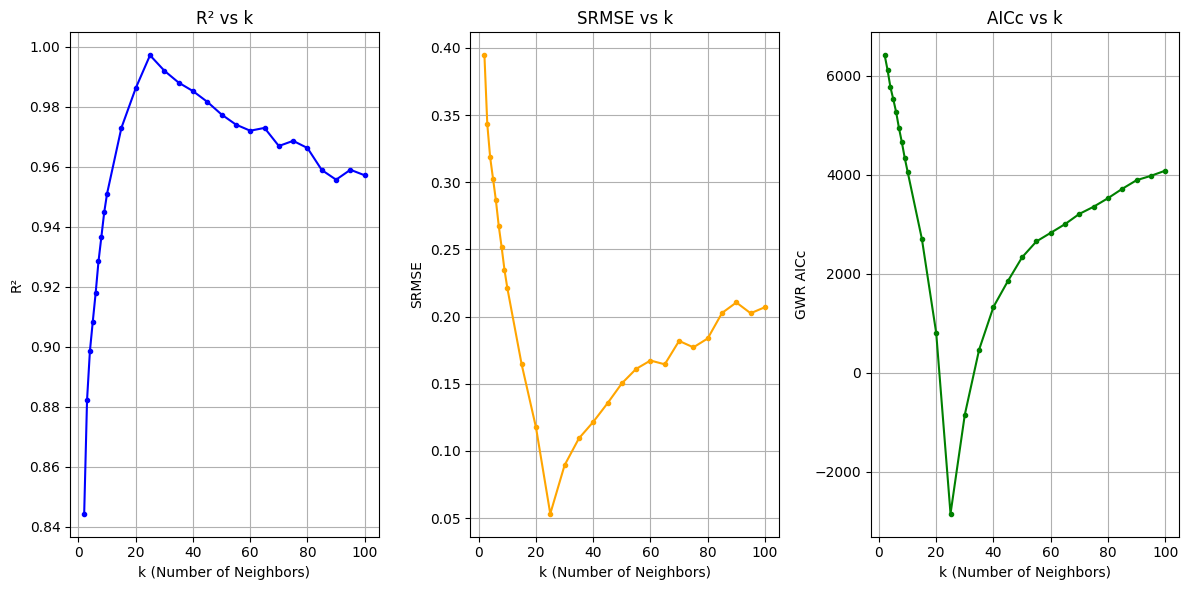

In [104]:
plt.figure(figsize=(12, 6))

# Plot R²
plt.subplot(1, 3, 1)
plt.plot(k_values, r2_list, color='blue', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R²')
plt.title('R² vs k')
plt.grid()

# Plot SRMSE
plt.subplot(1, 3, 2)
plt.plot(k_values, srmse_list, color='orange', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('SRMSE')
plt.title('SRMSE vs k')
plt.grid()


# Plot AIcc
plt.subplot(1, 3, 3)
plt.plot(k_values, aicc_list, color='green', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('GWR AICc')
plt.title('AICc vs k')
plt.grid()

plt.tight_layout()
plt.show()

### Aggregations

#### 48x48

In [105]:
S1_gdf = gpd.GeoDataFrame({'X': S1, 'geometry': gpd.points_from_xy(loc1[:, 0], loc1[:, 1])})

In [106]:
S1_gdf

X                 geometry
0    -0.713598   POINT (32.857 197.992)
1    -0.080170  POINT (204.138 595.669)
2    -0.377087  POINT (536.507 155.182)
3     0.825593    POINT (6.775 422.464)
4     2.219904  POINT (396.912 484.592)
...        ...                      ...
3595 -1.260541   POINT (237.294 369.16)
3596  2.081240  POINT (253.043 288.905)
3597 -1.637324  POINT (342.353 125.307)
3598 -1.188416   POINT (394.937 184.82)
3599 -1.845877     POINT (5.464 75.523)

[3600 rows x 2 columns]

In [107]:
# Spatial join: assign S1 points to 48x48 tracts
S1_agg = gpd.sjoin(S1_gdf, tracts_gdf48, how="left", predicate="within")

In [108]:
S1_agg = S1_agg.groupby("tract_id")["X"].mean().reset_index()
X_48x48 = tracts_gdf48.merge(S1_agg, on="tract_id", how="left")
X_48x48['y'] = y_orig

In [109]:
sX1_48 = X_48x48.copy()
sX1_48.isna().sum()

tract_id      0
geometry      0
sX            0
X           806
y             0
dtype: int64

In [110]:
sX1_48.dropna(inplace=True)
sX1_48.isna().sum()

tract_id    0
geometry    0
sX          0
X           0
y           0
dtype: int64

In [111]:
gwr_X  = sX1_48['X'].values.reshape(-1,1)
gwr_y = sX1_48['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_48['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((1498, 1), (1498, 1))

In [112]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw48 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw48, constant=False).fit()
print(gwr_bw48)

22.0


In [113]:
params48 = gwr_results.params
y_pred48 = gwr_results.predy
aicc_gwr48 = gwr_results.aicc
r2_48 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

4448.88181944953
0.8322917546563605


In [114]:
## calculating the standardized root mean squared error
y_true48 = sX1_48['y'].values.reshape(-1,1)
rmse48  = np.sqrt(np.mean((y_true48 - y_pred48)**2))
std_dev48 = np.std(y_true48)
srmse48 = rmse48 / std_dev48
srmse48, rmse48

(np.float64(0.4095219717471084), np.float64(0.9389407438870969))

#### 24x24

In [115]:
x_step, y_step = 25, 25 # Creates a 24x24 grid, resulting in 576 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_24 = np.array([[point.x, point.y] for point in tracts_gdf24.geometry.centroid])

In [116]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [117]:
# Spatial join X to 24x24 tracts 
spj24_X = gpd.sjoin(S1_gdf, tracts_gdf24, how='right', predicate='within')
agg_24_X = spj24_X.groupby('tract_id')[['X']].mean().reset_index()

In [118]:
# Spatial join y @ 48x48 to 24x24 tracts. Extract only the y from the df: line 2. 
spj24_y = gpd.sjoin(X_48x48, tracts_gdf24, how='right', predicate='within')
agg_24_y = spj24_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [119]:
agg_24 = agg_24_X.merge(agg_24_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [120]:
# Aggregate X & Y within each 24x24 grid cell
GWR_24x24_gdf = tracts_gdf24.merge(agg_24, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [121]:
sX1_24 = GWR_24x24_gdf.copy()
sX1_24.isna().sum()

tract_id           0
geometry           0
X                 23
tract_id_right     0
y                  0
dtype: int64

In [122]:
sX1_24.dropna(inplace=True)
sX1_24.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [123]:
gwr_X  = sX1_24['X'].values.reshape(-1,1)
gwr_y = sX1_24['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_24['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((553, 1), (553, 1))

In [124]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw24 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw24, constant=False).fit()
print(gwr_bw24)

30.0


In [125]:
params24 = gwr_results.params
y_pred24 = gwr_results.predy
aicc_gwr24 = gwr_results.aicc
r2_24 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

1583.9331904901626
0.8133103672148672


In [126]:
## calculating the standardized root mean squared error
y_true24 = sX1_24['y'].values.reshape(-1,1)
rmse24  = np.sqrt(np.mean((y_true24 - y_pred24)**2))
std_dev24 = np.std(y_true24)
srmse24 = rmse24 / std_dev24
srmse24, rmse24

(np.float64(0.432075957194025), np.float64(0.921656693570816))

#### 16x16

In [127]:
x_step, y_step = 37.5, 37.5 # Creates a 32x32 grid, resulting in 576 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_16 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])

In [128]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [129]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [130]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [131]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [132]:
# Aggregate X & y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [133]:
sX1_16 = GWR_16x16_gdf.copy()

gwr_X  = sX1_16['X'].values.reshape(-1,1)
gwr_y = sX1_16['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_16['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [134]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw16 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw16, constant=False).fit()
print(gwr_bw16)

26.0


In [135]:
params16 = gwr_results.params
y_pred16 = gwr_results.predy
aicc_gwr16 = gwr_results.aicc
r2_16 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

630.0482914813769
0.8680894490144633


In [136]:
## calculating the standardized root mean squared error
y_true16 = sX1_16['y'].values.reshape(-1,1)
rmse16  = np.sqrt(np.mean((y_true16 - y_pred16)**2))
std_dev16 = np.std(y_true16)
srmse16 = rmse16 / std_dev16
srmse16, rmse16

(np.float64(0.3631949214754204), np.float64(0.7427073078066659))

#### 12x12

In [137]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 50, 50  # Creates a 12x12 grid, resulting in 144 tracts cell divisions
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_12 = np.array([[point.x, point.y] for point in tracts_gdf12.geometry.centroid])

In [138]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [139]:
# Spatial join X to 12x12 tracts 
spj12_X = gpd.sjoin(S1_gdf, tracts_gdf12, how='right', predicate='within')
agg_12_X = spj12_X.groupby('tract_id')[['X']].mean().reset_index()

In [140]:
# Spatial join y @ 48x48 to 12x12 tracts. Extract only the y from the df: line 2. 
spj12_y = gpd.sjoin(X_48x48, tracts_gdf12, how='right', predicate='within')
agg_12_y = spj12_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [141]:
agg_12 = agg_12_X.merge(agg_12_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [142]:
# Aggregate X & Y within each 24x24 grid cell
GWR_12x12_gdf = tracts_gdf12.merge(agg_12, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [143]:
sX1_12 = GWR_12x12_gdf.copy()
sX1_12.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [144]:
gwr_X  = sX1_12['X'].values.reshape(-1,1)
gwr_y = sX1_12['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_12['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((144, 1), (144, 1))

In [145]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw12 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw12, constant=False).fit()
print(gwr_bw12)

25.0


In [146]:
params12 = gwr_results.params
y_pred12 = gwr_results.predy
aicc_gwr12 = gwr_results.aicc
r2_12 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

283.08850159357803
0.9141156047755827


In [147]:
## calculating the standardized root mean squared error
y_true12 = sX1_12['y'].values.reshape(-1,1)
rmse12  = np.sqrt(np.mean((y_true12 - y_pred12)**2))
std_dev12 = np.std(y_true12)
srmse12 = rmse12 / std_dev12
srmse12, rmse12

(np.float64(0.2930603951823196), np.float64(0.5709004245319592))

#### 8x8

In [148]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 8x8 grid, resulting in 256 tracts cell divisions
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_8 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])

In [149]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [150]:
# Spatial join X to 8x8 tracts 
spj8_X = gpd.sjoin(S1_gdf, tracts_gdf8, how='right', predicate='within')
agg_8_X = spj8_X.groupby('tract_id')[['X']].mean().reset_index()

In [151]:
# Spatial join y @ 48x48 to 8x8 tracts. Extract only the y from the df: line 2. 
spj8_y = gpd.sjoin(X_48x48, tracts_gdf8, how='right', predicate='within')
agg_8_y = spj8_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [152]:
agg_8 = agg_8_X.merge(agg_8_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [153]:
# Aggregate X & Y within each 24x24 grid cell
GWR_8x8_gdf = tracts_gdf8.merge(agg_8, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [154]:
sX1_8 = GWR_8x8_gdf.copy()
sX1_8.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [155]:
gwr_X  = sX1_8['X'].values.reshape(-1,1)
gwr_y = sX1_8['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_8['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [156]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw8 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw8, constant=False).fit()
print(gwr_bw8)

22.0


In [157]:
params8 = gwr_results.params
y_pred8 = gwr_results.predy
aicc_gwr8 = gwr_results.aicc
r2_8 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

77.34812742978653
0.9468237321329247


In [158]:
## calculating the standardized root mean squared error
y_true8 = sX1_8['y'].values.reshape(-1,1)
rmse8  = np.sqrt(np.mean((y_true8 - y_pred8)**2))
std_dev8 = np.std(y_true8)
srmse8 = rmse8 / std_dev8
srmse8, rmse8

(np.float64(0.23059980023208018), np.float64(0.3824197016790286))

#### table

In [159]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [160]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [161]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [162]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24    16x16    12x12      8x8
BW         22.0000  30.0000  26.0000  25.0000  22.0000
R²          0.8323   0.8133   0.8681   0.9141   0.9468
SRMSE       0.4095   0.4321   0.3632   0.2931   0.2306

#### Visualizations

##### 48x48

In [163]:
loc2_48 = np.array([[point.x, point.y] for point in sX1_48.geometry.centroid])

In [164]:
sX1_48['params48'] = params48
sX1_48

tracts_gdf48_points = tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj48_48 = gpd.sjoin(tracts_gdf48_points, sX1_48, how='left', predicate='within')
spj48_48['y'] = y_orig

tracts_gdf48["X_48x48"] = spj48_48["X"]
tracts_gdf48['y_48x48'] = spj48_48["y"]
tracts_gdf48['est_beta48'] = spj48_48["params48"]


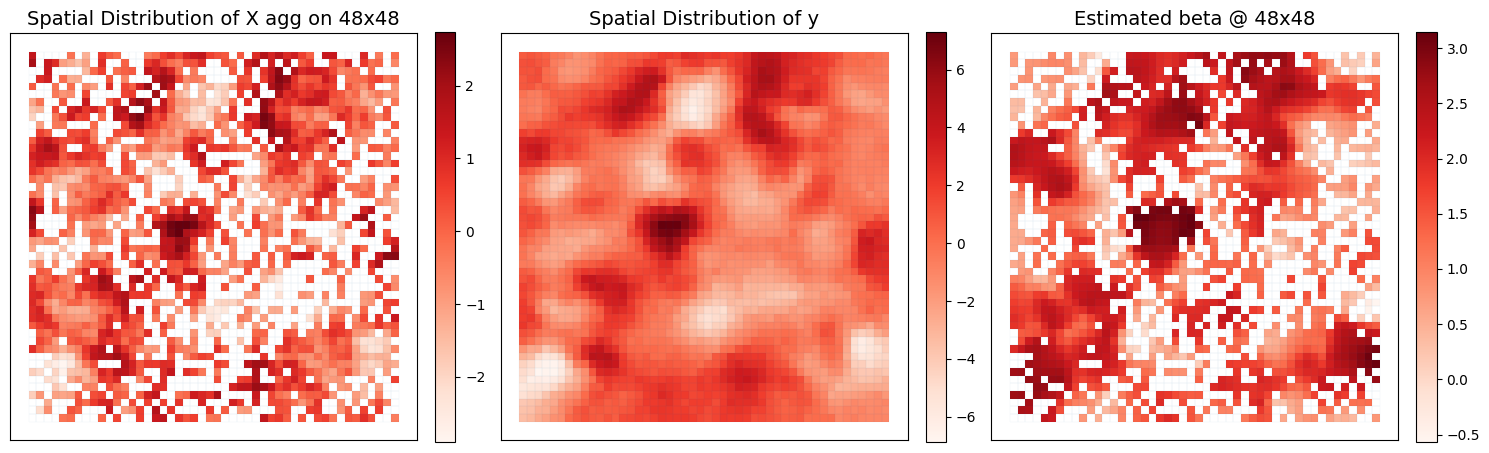

In [165]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.Reds
cmap3 = plt.cm.Reds

# Plot 1 - X_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 48x48", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta48", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 48x48", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 24x24

In [166]:
sX1_24['params24'] = params24
sX1_24

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj24_48 = gpd.sjoin(tracts_gdf48_points, sX1_24, how='left', predicate='within')

In [167]:
tracts_gdf48["X_24x24"] = spj24_48["X"]
tracts_gdf48['y_24x24'] = spj24_48["y"]
tracts_gdf48['est_beta24'] = spj24_48["params24"]

In [168]:
spj24_48["X"]

0      -2.137928
1      -2.137928
2      -1.336631
3      -1.336631
4            NaN
          ...   
2299   -0.809597
2300   -0.156722
2301   -0.156722
2302   -0.349581
2303   -0.349581
Name: X, Length: 2304, dtype: float64

In [169]:
tracts_gdf48['est_beta24'].isna().sum()

np.int64(92)

In [170]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [171]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [172]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [173]:
# Aggregate X & Y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

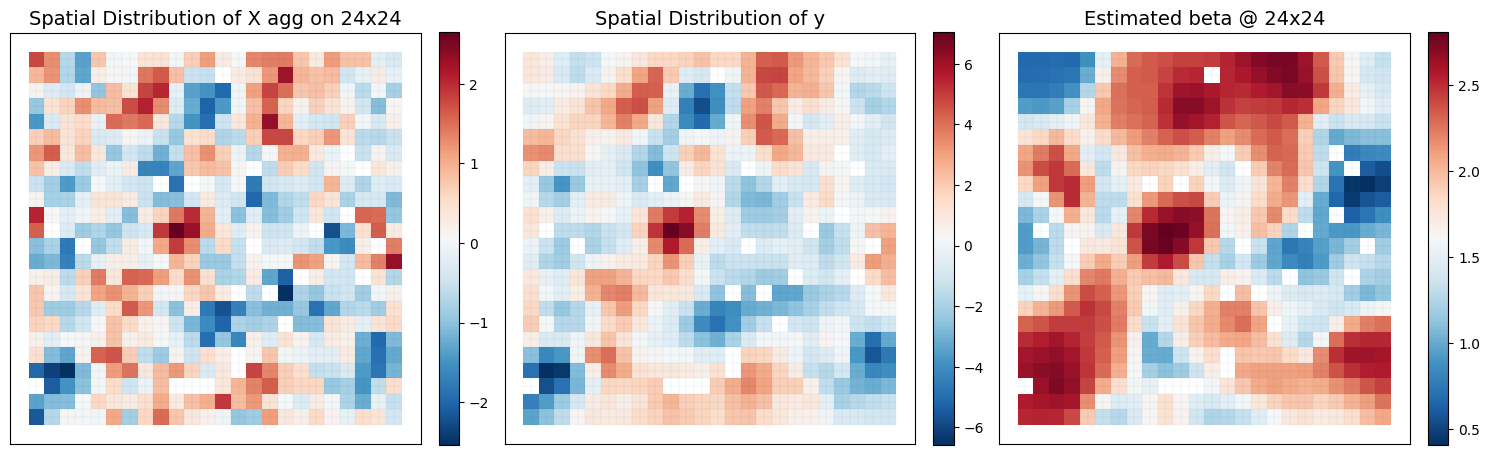

In [174]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 24x24", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta24", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 24x24", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 16x16

In [175]:
sX1_16['params16'] = params16
sX1_16

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj16_48 = gpd.sjoin(tracts_gdf48_points, sX1_16, how='left', predicate='within')

In [176]:
tracts_gdf48["X_16x16"] = spj16_48["X"]
tracts_gdf48['y_16x16'] = spj16_48["y"]
tracts_gdf48['est_beta16'] = spj16_48["params16"]

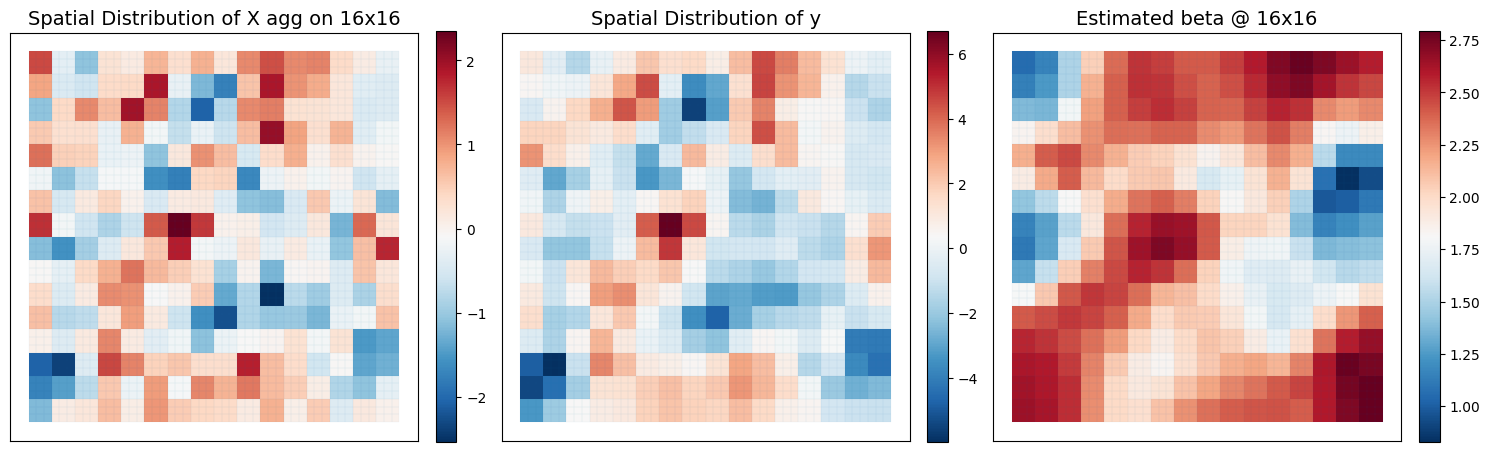

In [177]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 16x16", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta16", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 16x16", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 12x12

In [178]:
sX1_12['params12'] = params12
sX1_12

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj12_48 = gpd.sjoin(tracts_gdf48_points, sX1_12, how='left', predicate='within')

In [179]:
tracts_gdf48["X_12x12"] = spj12_48["X"]
tracts_gdf48['y_12x12'] = spj12_48["y"]
tracts_gdf48['est_beta12'] = spj12_48["params12"]

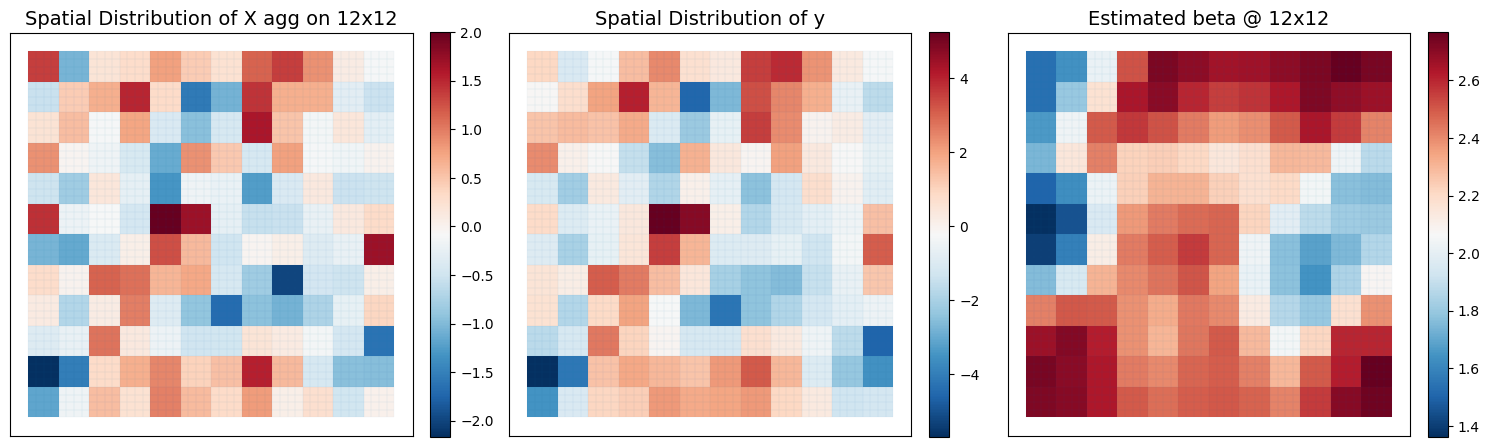

In [180]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 12x12", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta12", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 12x12", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 8x8

In [181]:
sX1_8['params8'] = params8

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj8_48 = gpd.sjoin(tracts_gdf48_points, sX1_8, how='left', predicate='within')

In [182]:
tracts_gdf48["X_8x8"] = spj8_48["X"]
tracts_gdf48['y_8x8'] = spj8_48["y"]
tracts_gdf48['est_beta8'] = spj8_48["params8"]

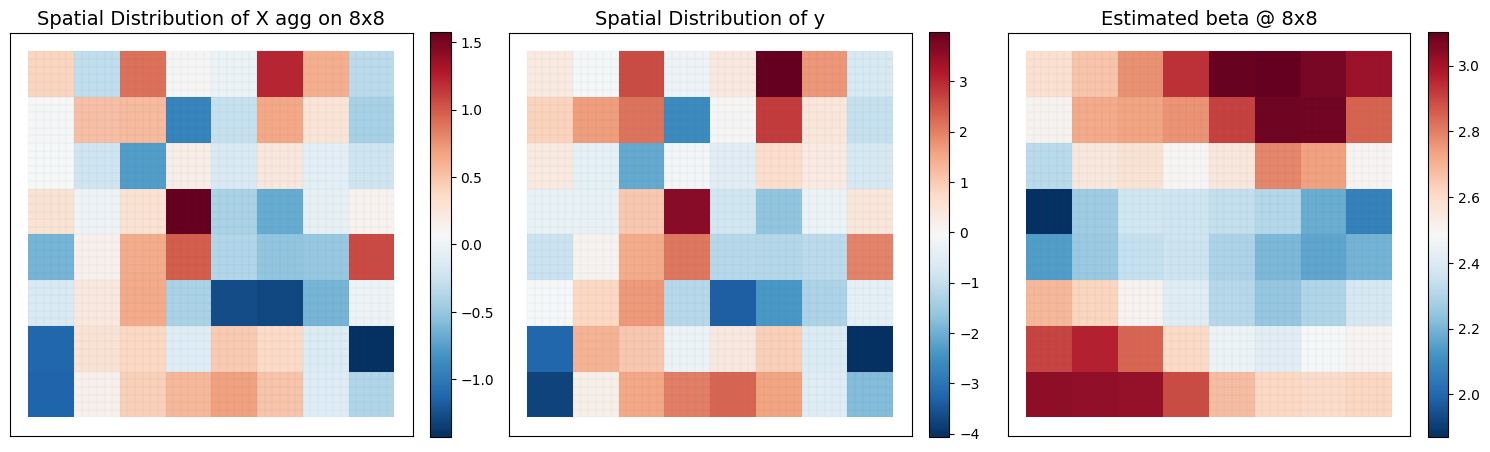

In [183]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 8x8", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta8", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 8x8", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [184]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="X_48x48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("X @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="X_24x24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("X @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="X_16x16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("X @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="X_12x12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("X @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="X_8x8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("X @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


In [185]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="y_48x48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("y @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="y_24x24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("y @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="y_16x16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("y @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="y_12x12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("y @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="y_8x8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("y @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


In [186]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="est_beta48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("beta @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="est_beta24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("beta @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="est_beta16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("beta @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="est_beta12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("beta @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="est_beta8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("beta @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


##### general viz

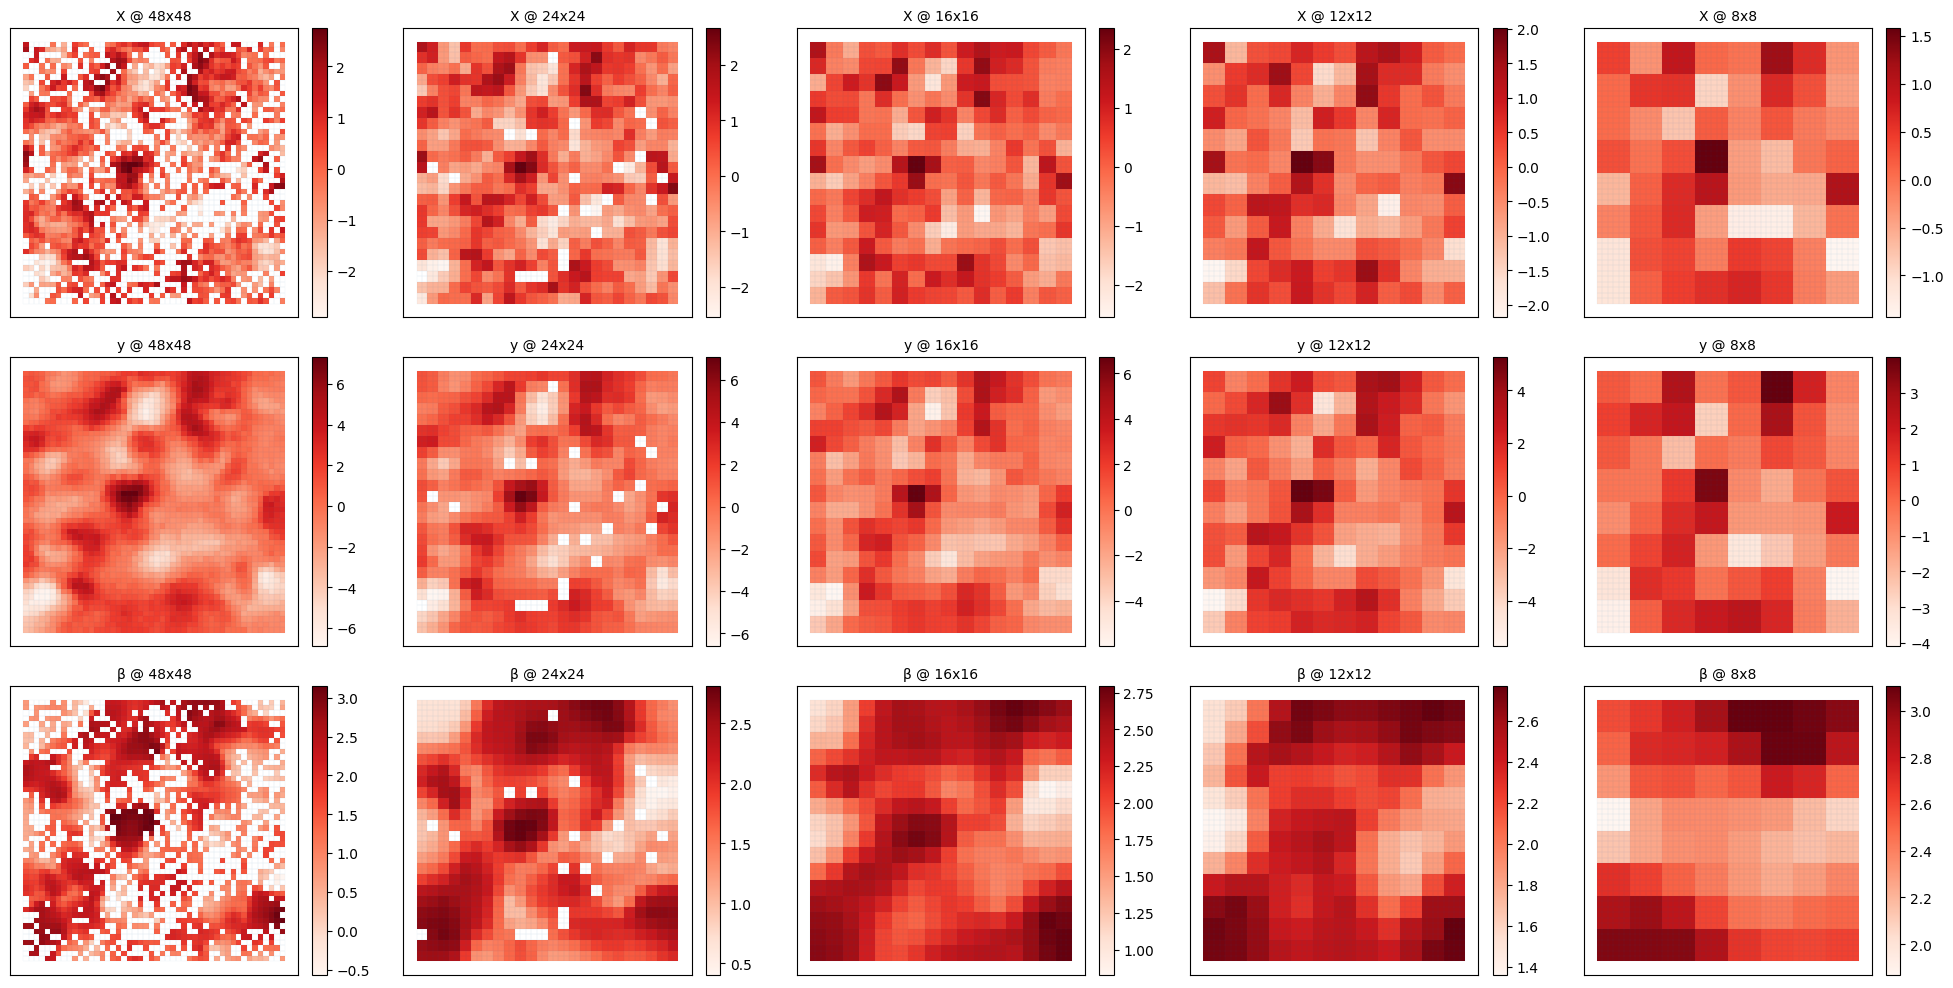

In [187]:
res_labels = ["48x48", "24x24", "16x16", "12x12", "8x8"]
x_cols = ["X_48x48", "X_24x24", "X_16x16", "X_12x12", "X_8x8"]
y_cols = ["y_48x48", "y_24x24", "y_16x16", "y_12x12", "y_8x8"]
beta_cols = ["est_beta48", "est_beta24", "est_beta16", "est_beta12", "est_beta8"]
titles = ["X", "y", "β"]
cmap = plt.cm.Reds

# Create a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(20, 10))

# Loop through each row (X, y, β) and each column (resolutions)
for row, cols in enumerate([x_cols, y_cols, beta_cols]):
    for col, colname in enumerate(cols):
        ax = axes[row, col]
        
        # Base map (light boundary layer)
        tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax)
        
        # Choropleth plot
        tracts_gdf48.plot(column=colname, cmap=cmap, edgecolor="face", linewidth=0, ax=ax, legend=False)
        
        # Normalize for consistent colorbar
        norm = mcolors.Normalize(vmin=tracts_gdf48[colname].min(), vmax=tracts_gdf48[colname].max())
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        
        # Title and layout tweaks
        ax.set_title(f"{titles[row]} @ {res_labels[col]}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


## K = 250

In [188]:
# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts 
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

In [189]:
B = uniform_beta.flatten()

nbrs_S2 = NearestNeighbors(n_neighbors=250).fit(loc1)

smoothed_S1_to_S2 = np.zeros(len(S2))

for i in range(len(S2)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc2[i]])
    smoothed_S1_to_S2[i] = np.mean(S1[indices_S1_to_S2[0]].flatten())


np.random.seed(26)

error_term = np.random.normal(0, 0.1, len(S2))

y_orig = B * smoothed_S1_to_S2 + error_term

<Figure size 1000x800 with 0 Axes>

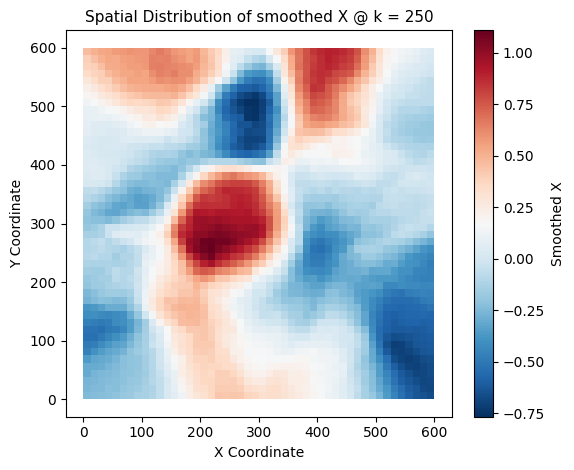

In [190]:
plt.figure(figsize=(10, 8))

# Assign smoothed values
tracts_gdf48['sX'] = smoothed_S1_to_S2

# Plot the choropleth map
ax = tracts_gdf48.plot(
    column="sX",
    cmap=plt.cm.RdBu_r,
    edgecolor="face",
    linewidth=0,
    legend=False
)

# Create scalar mappable for colorbar
norm = mcolors.Normalize(
    vmin=tracts_gdf48["sX"].min(),
    vmax=tracts_gdf48["sX"].max()
)
sm = cm.ScalarMappable(norm=norm, cmap=plt.cm.RdBu_r)
sm._A = []  # workaround to enable colorbar for ScalarMappable

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Smoothed X")

# Add labels and title
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Spatial Distribution of smoothed X @ k = 250", fontsize=11)

plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

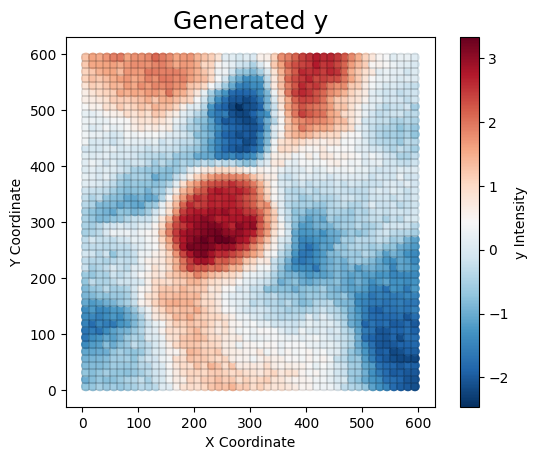

In [191]:
plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
cmap = plt.cm.RdBu_r

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=y_orig, cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Generated y", fontsize=18)

plt.show()

In [192]:
r2_list = []
srmse_list = []
bw_list = []
aicc_list = []

part1 = list(range(2, 11, 1))
part2 = list(range(15, 101, 5))
part3 = list(range(125, 1001, 25))

k_values = part1 + part2 + part3

for k in k_values:
    # --- 1. Smooth point-level X (S1) to polygon-level (S2 centroids) ---
    nbrs_S1 = NearestNeighbors(n_neighbors=k).fit(loc1)  # loc1 = point locations
    smoothed_S1_to_S2 = np.zeros(len(loc2))  # loc2 = tract centroids
    
    for i in range(len(loc2)):
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])
        bw_S1 = distances_S1_to_S2[0][-1]
        weights_X = np.exp(-0.5 * (distances_S1_to_S2[0] / bw_S1) ** 2)
        local_X = S1[indices_S1_to_S2[0]]  # S1 = point-level X
        smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)
    
    # --- 3. Fit GWR at polygon level ---
    coords = loc2  # tract centroids
    X_design = smoothed_S1_to_S2.reshape(-1,1)
    y_design = y_orig.reshape(-1,1)
    
    bw = Sel_BW(coords, y_design, X_design, constant=False).search(bw_min=2)
    gwr_model = GWR(coords, y_design, X_design, bw, constant=False)
    gwr_results = gwr_model.fit()
    
    # --- 4. Extract metrics ---
    y_pred = gwr_results.predy.flatten()
    r2 = r2_score(y_orig, y_pred)
    srmse = np.sqrt(mean_squared_error(y_orig, y_pred)) / np.std(y_orig)
    aicc = gwr_results.aicc
    
    r2_list.append(r2)
    srmse_list.append(srmse)
    bw_list.append(bw)
    aicc_list.append(aicc)
    
    print(f"k={k}: R2={r2:.4f}, SRMSE={srmse:.4f}, AICc={aicc:.4f}, BW={bw:.4f}")

k=2: R2=0.6693, SRMSE=0.5750, AICc=5578.2960, BW=20.0000
k=3: R2=0.7001, SRMSE=0.5477, AICc=5387.5135, BW=14.0000
k=4: R2=0.7127, SRMSE=0.5360, AICc=5283.7335, BW=15.0000
k=5: R2=0.7213, SRMSE=0.5279, AICc=5203.0952, BW=14.0000
k=6: R2=0.7308, SRMSE=0.5189, AICc=5107.2486, BW=18.0000
k=7: R2=0.7433, SRMSE=0.5066, AICc=4997.8059, BW=14.0000
k=8: R2=0.7447, SRMSE=0.5053, AICc=4979.2637, BW=14.0000
k=9: R2=0.7505, SRMSE=0.4995, AICc=4923.9346, BW=14.0000
k=10: R2=0.7557, SRMSE=0.4942, AICc=4875.8670, BW=14.0000
k=15: R2=0.7728, SRMSE=0.4767, AICc=4712.6910, BW=14.0000
k=20: R2=0.8029, SRMSE=0.4439, AICc=4388.2996, BW=14.0000
k=25: R2=0.8292, SRMSE=0.4132, AICc=4070.0082, BW=15.0000
k=30: R2=0.8415, SRMSE=0.3981, AICc=3899.6142, BW=17.0000
k=35: R2=0.8447, SRMSE=0.3941, AICc=3819.7557, BW=19.0000
k=40: R2=0.8486, SRMSE=0.3891, AICc=3798.2042, BW=17.0000
k=45: R2=0.8553, SRMSE=0.3804, AICc=3711.8169, BW=14.0000
k=50: R2=0.8640, SRMSE=0.3687, AICc=3574.2122, BW=15.0000
k=55: R2=0.8711, SRMSE

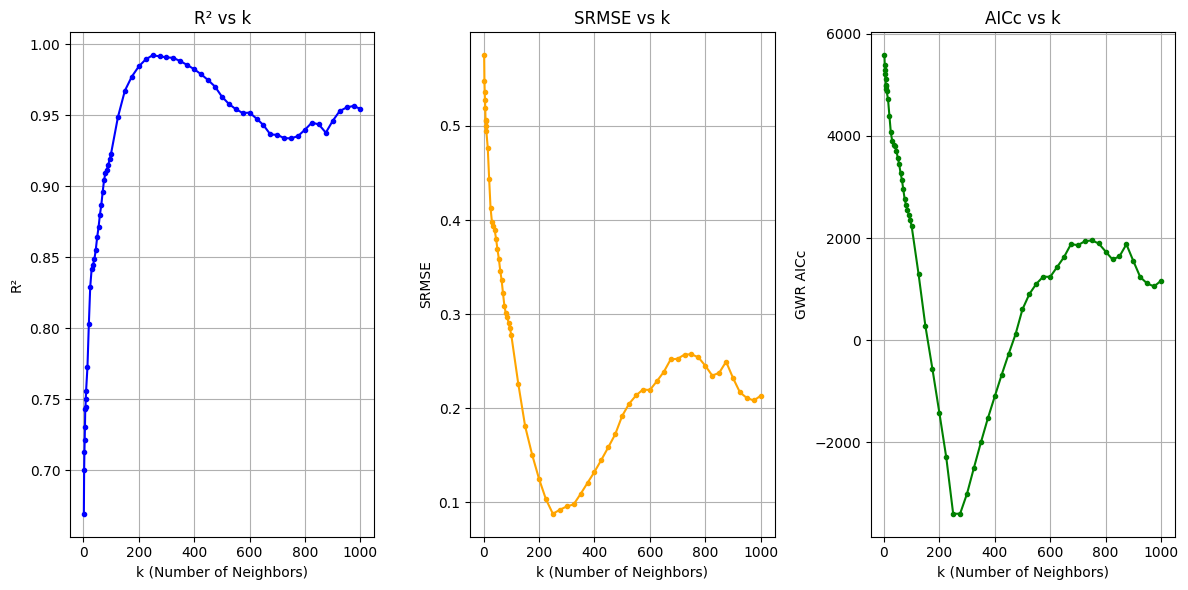

In [193]:
plt.figure(figsize=(12, 6))

# Plot R²
plt.subplot(1, 3, 1)
plt.plot(k_values, r2_list, color='blue', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R²')
plt.title('R² vs k')
plt.grid()

# Plot SRMSE
plt.subplot(1, 3, 2)
plt.plot(k_values, srmse_list, color='orange', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('SRMSE')
plt.title('SRMSE vs k')
plt.grid()


# Plot AIcc
plt.subplot(1, 3, 3)
plt.plot(k_values, aicc_list, color='green', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('GWR AICc')
plt.title('AICc vs k')
plt.grid()

plt.tight_layout()
plt.show()

### Aggregations

#### 48x48

In [194]:
S1_gdf = gpd.GeoDataFrame({'X': S1, 'geometry': gpd.points_from_xy(loc1[:, 0], loc1[:, 1])})

In [195]:
S1_gdf

X                 geometry
0    -0.713598   POINT (32.857 197.992)
1    -0.080170  POINT (204.138 595.669)
2    -0.377087  POINT (536.507 155.182)
3     0.825593    POINT (6.775 422.464)
4     2.219904  POINT (396.912 484.592)
...        ...                      ...
3595 -1.260541   POINT (237.294 369.16)
3596  2.081240  POINT (253.043 288.905)
3597 -1.637324  POINT (342.353 125.307)
3598 -1.188416   POINT (394.937 184.82)
3599 -1.845877     POINT (5.464 75.523)

[3600 rows x 2 columns]

In [196]:
# Spatial join: assign S1 points to 48x48 tracts
S1_agg = gpd.sjoin(S1_gdf, tracts_gdf48, how="left", predicate="within")

In [197]:
S1_agg = S1_agg.groupby("tract_id")["X"].mean().reset_index()
X_48x48 = tracts_gdf48.merge(S1_agg, on="tract_id", how="left")
X_48x48['y'] = y_orig

In [198]:
sX1_48 = X_48x48.copy()
sX1_48.isna().sum()

tract_id      0
geometry      0
sX            0
X           806
y             0
dtype: int64

In [199]:
sX1_48.dropna(inplace=True)
sX1_48.isna().sum()

tract_id    0
geometry    0
sX          0
X           0
y           0
dtype: int64

In [200]:
gwr_X  = sX1_48['X'].values.reshape(-1,1)
gwr_y = sX1_48['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_48['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((1498, 1), (1498, 1))

In [201]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw48 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw48, constant=False).fit()
print(gwr_bw48)

21.0


In [202]:
params48 = gwr_results.params
y_pred48 = gwr_results.predy
aicc_gwr48 = gwr_results.aicc
r2_48 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

3901.2320416542766
0.5931435511107825


In [203]:
## calculating the standardized root mean squared error
y_true48 = sX1_48['y'].values.reshape(-1,1)
rmse48  = np.sqrt(np.mean((y_true48 - y_pred48)**2))
std_dev48 = np.std(y_true48)
srmse48 = rmse48 / std_dev48
srmse48, rmse48

(np.float64(0.6378529994357772), np.float64(0.7727700292744014))

#### 24x24

In [204]:
x_step, y_step = 25, 25 # Creates a 24x24 grid, resulting in 576 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_24 = np.array([[point.x, point.y] for point in tracts_gdf24.geometry.centroid])

In [205]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [206]:
# Spatial join X to 24x24 tracts 
spj24_X = gpd.sjoin(S1_gdf, tracts_gdf24, how='right', predicate='within')
agg_24_X = spj24_X.groupby('tract_id')[['X']].mean().reset_index()

In [207]:
# Spatial join y @ 48x48 to 24x24 tracts. Extract only the y from the df: line 2. 
spj24_y = gpd.sjoin(X_48x48, tracts_gdf24, how='right', predicate='within')
agg_24_y = spj24_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [208]:
agg_24 = agg_24_X.merge(agg_24_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [209]:
# Aggregate X & Y within each 24x24 grid cell
GWR_24x24_gdf = tracts_gdf24.merge(agg_24, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [210]:
sX1_24 = GWR_24x24_gdf.copy()
sX1_24.isna().sum()

tract_id           0
geometry           0
X                 23
tract_id_right     0
y                  0
dtype: int64

In [211]:
sX1_24.dropna(inplace=True)
sX1_24.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [212]:
gwr_X  = sX1_24['X'].values.reshape(-1,1)
gwr_y = sX1_24['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_24['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((553, 1), (553, 1))

In [213]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw24 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw24, constant=False).fit()
print(gwr_bw24)

35.0


In [214]:
params24 = gwr_results.params
y_pred24 = gwr_results.predy
aicc_gwr24 = gwr_results.aicc
r2_24 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

1546.6850811922036
0.4149857154841913


In [215]:
## calculating the standardized root mean squared error
y_true24 = sX1_24['y'].values.reshape(-1,1)
rmse24  = np.sqrt(np.mean((y_true24 - y_pred24)**2))
std_dev24 = np.std(y_true24)
srmse24 = rmse24 / std_dev24
srmse24, rmse24

(np.float64(0.7648622650620233), np.float64(0.9002215658787156))

#### 16x16

In [216]:
x_step, y_step = 37.5, 37.5 # Creates a 32x32 grid, resulting in 576 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_16 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])

In [217]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [218]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [219]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [220]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [221]:
# Aggregate X & y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [222]:
sX1_16 = GWR_16x16_gdf.copy()

gwr_X  = sX1_16['X'].values.reshape(-1,1)
gwr_y = sX1_16['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_16['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [223]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw16 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw16, constant=False).fit()
print(gwr_bw16)

37.0


In [224]:
params16 = gwr_results.params
y_pred16 = gwr_results.predy
aicc_gwr16 = gwr_results.aicc
r2_16 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

706.5735374656551
0.4048804929104969


In [225]:
## calculating the standardized root mean squared error
y_true16 = sX1_16['y'].values.reshape(-1,1)
rmse16  = np.sqrt(np.mean((y_true16 - y_pred16)**2))
std_dev16 = np.std(y_true16)
srmse16 = rmse16 / std_dev16
srmse16, rmse16

(np.float64(0.7714398920781211), np.float64(0.885101776287236))

#### 12x12

In [226]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 50, 50  # Creates a 12x12 grid, resulting in 144 tracts cell divisions
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_12 = np.array([[point.x, point.y] for point in tracts_gdf12.geometry.centroid])

In [227]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [228]:
# Spatial join X to 12x12 tracts 
spj12_X = gpd.sjoin(S1_gdf, tracts_gdf12, how='right', predicate='within')
agg_12_X = spj12_X.groupby('tract_id')[['X']].mean().reset_index()

In [229]:
# Spatial join y @ 48x48 to 12x12 tracts. Extract only the y from the df: line 2. 
spj12_y = gpd.sjoin(X_48x48, tracts_gdf12, how='right', predicate='within')
agg_12_y = spj12_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [230]:
agg_12 = agg_12_X.merge(agg_12_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [231]:
# Aggregate X & Y within each 12x12 grid cell
GWR_12x12_gdf = tracts_gdf12.merge(agg_12, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [232]:
sX1_12 = GWR_12x12_gdf.copy()
sX1_12.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [233]:
gwr_X  = sX1_12['X'].values.reshape(-1,1)
gwr_y = sX1_12['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_12['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((144, 1), (144, 1))

In [234]:
coords.shape, gwr_y.shape, gwr_X.shape

((144, 2), (144, 1), (144, 1))

In [235]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw12 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw12, constant=False).fit()
print(gwr_bw12)

36.0


In [236]:
params12 = gwr_results.params
y_pred12 = gwr_results.predy
aicc_gwr12 = gwr_results.aicc
r2_12 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

393.02293007772477
0.409234835053202


In [237]:
## calculating the standardized root mean squared error
y_true12 = sX1_12['y'].values.reshape(-1,1)
rmse12  = np.sqrt(np.mean((y_true12 - y_pred12)**2))
std_dev12 = np.std(y_true12)
srmse12 = rmse12 / std_dev12
srmse12, rmse12

(np.float64(0.7686124933585181), np.float64(0.8661977958267987))

#### 8x8

In [238]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 8x8 grid, resulting in 256 tracts cell divisions
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_8 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])

In [239]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [240]:
# Spatial join X to 8x8 tracts 
spj8_X = gpd.sjoin(S1_gdf, tracts_gdf8, how='right', predicate='within')
agg_8_X = spj8_X.groupby('tract_id')[['X']].mean().reset_index()

In [241]:
# Spatial join y @ 48x48 to 8x8 tracts. Extract only the y from the df: line 2. 
spj8_y = gpd.sjoin(X_48x48, tracts_gdf8, how='right', predicate='within')
agg_8_y = spj8_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [242]:
agg_8 = agg_8_X.merge(agg_8_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [243]:
# Aggregate X & Y within each 24x24 grid cell
GWR_8x8_gdf = tracts_gdf8.merge(agg_8, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [244]:
sX1_8 = GWR_8x8_gdf.copy()
sX1_8.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [245]:
gwr_X  = sX1_8['X'].values.reshape(-1,1)
gwr_y = sX1_8['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_8['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [246]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw8 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw8, constant=False).fit()
print(gwr_bw8)

33.0


In [247]:
params8 = gwr_results.params
y_pred8 = gwr_results.predy
aicc_gwr8 = gwr_results.aicc
r2_8 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

154.33671962502117
0.5313776893445084


In [248]:
## calculating the standardized root mean squared error
y_true8 = sX1_8['y'].values.reshape(-1,1)
rmse8  = np.sqrt(np.mean((y_true8 - y_pred8)**2))
std_dev8 = np.std(y_true8)
srmse8 = rmse8 / std_dev8
srmse8, rmse8

(np.float64(0.6845599394176464), np.float64(0.7314919755107789))

#### table

In [249]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [250]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [251]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [252]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24    16x16    12x12      8x8
BW         21.0000  35.0000  37.0000  36.0000  33.0000
R²          0.5931   0.4150   0.4049   0.4092   0.5314
SRMSE       0.6379   0.7649   0.7714   0.7686   0.6846

#### Visualizations

##### 48x48

In [253]:
loc2_48 = np.array([[point.x, point.y] for point in sX1_48.geometry.centroid])

In [254]:
sX1_48['params48'] = params48
sX1_48

tracts_gdf48_points = tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj48_48 = gpd.sjoin(tracts_gdf48_points, sX1_48, how='left', predicate='within')
spj48_48['y'] = y_orig

tracts_gdf48["X_48x48"] = spj48_48["X"]
tracts_gdf48['y_48x48'] = spj48_48["y"]
tracts_gdf48['est_beta48'] = spj48_48["params48"]


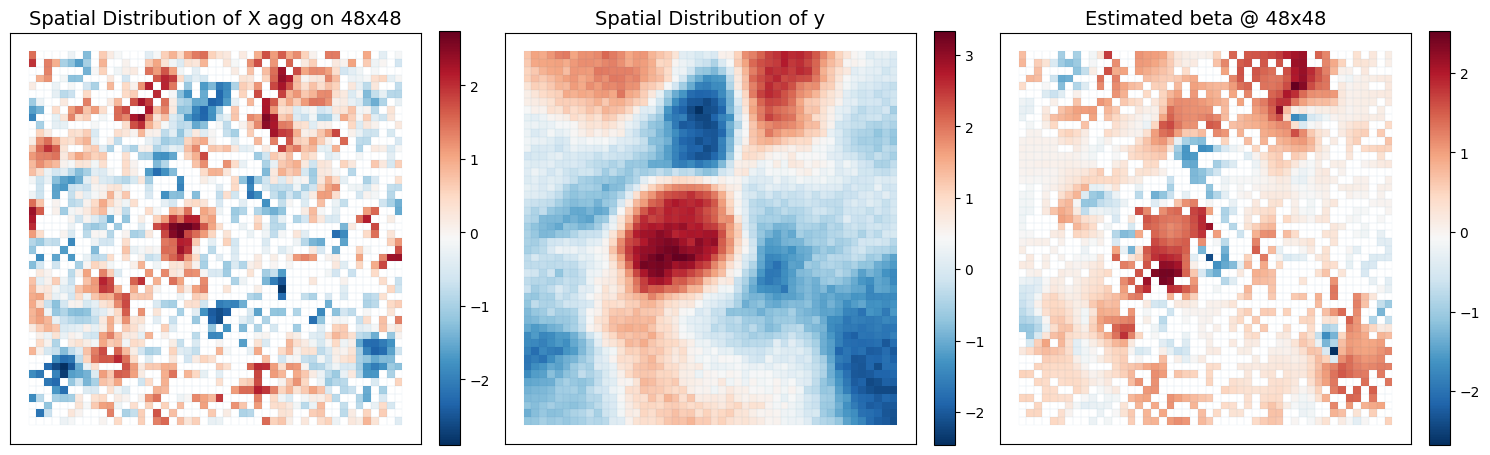

In [255]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 48x48", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta48", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 48x48", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 24x24

In [256]:
sX1_24['params24'] = params24
sX1_24

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj24_48 = gpd.sjoin(tracts_gdf48_points, sX1_24, how='left', predicate='within')

In [257]:
tracts_gdf48["X_24x24"] = spj24_48["X"]
tracts_gdf48['y_24x24'] = spj24_48["y"]
tracts_gdf48['est_beta24'] = spj24_48["params24"]

In [258]:
spj24_48["X"]

0      -2.137928
1      -2.137928
2      -1.336631
3      -1.336631
4            NaN
          ...   
2299   -0.809597
2300   -0.156722
2301   -0.156722
2302   -0.349581
2303   -0.349581
Name: X, Length: 2304, dtype: float64

In [259]:
tracts_gdf48['est_beta24'].isna().sum()

np.int64(92)

In [260]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [261]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [262]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [263]:
# Aggregate X & Y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

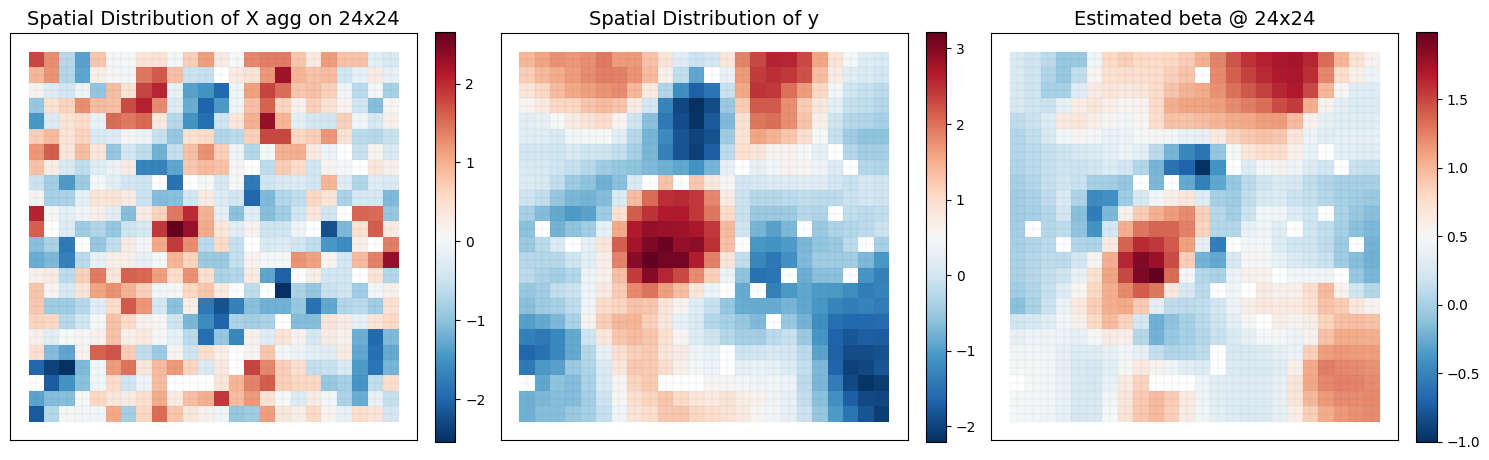

In [264]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 24x24", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta24", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 24x24", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 16x16

In [265]:
sX1_16['params16'] = params16
sX1_16

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj16_48 = gpd.sjoin(tracts_gdf48_points, sX1_16, how='left', predicate='within')

In [266]:
tracts_gdf48["X_16x16"] = spj16_48["X"]
tracts_gdf48['y_16x16'] = spj16_48["y"]
tracts_gdf48['est_beta16'] = spj16_48["params16"]

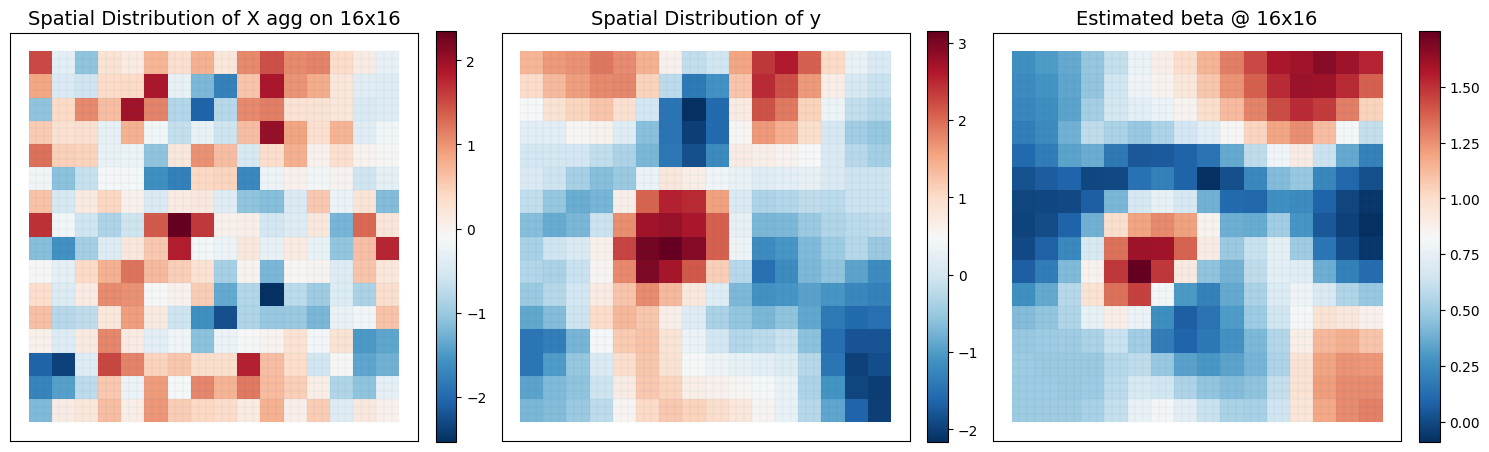

In [267]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 16x16", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta16", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 16x16", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 12x12

In [268]:
sX1_12['params12'] = params12
sX1_12

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj12_48 = gpd.sjoin(tracts_gdf48_points, sX1_12, how='left', predicate='within')

In [269]:
tracts_gdf48["X_12x12"] = spj12_48["X"]
tracts_gdf48['y_12x12'] = spj12_48["y"]
tracts_gdf48['est_beta12'] = spj12_48["params12"]

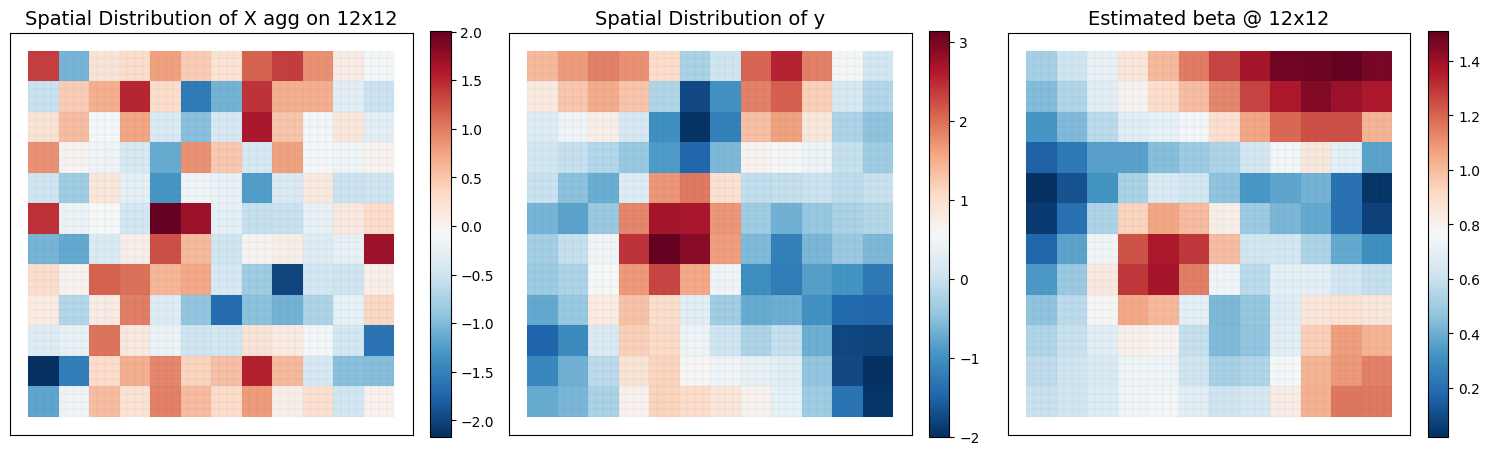

In [270]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 12x12", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta12", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 12x12", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 8x8

In [271]:
sX1_8['params8'] = params8

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj8_48 = gpd.sjoin(tracts_gdf48_points, sX1_8, how='left', predicate='within')

In [272]:
tracts_gdf48["X_8x8"] = spj8_48["X"]
tracts_gdf48['y_8x8'] = spj8_48["y"]
tracts_gdf48['est_beta8'] = spj8_48["params8"]

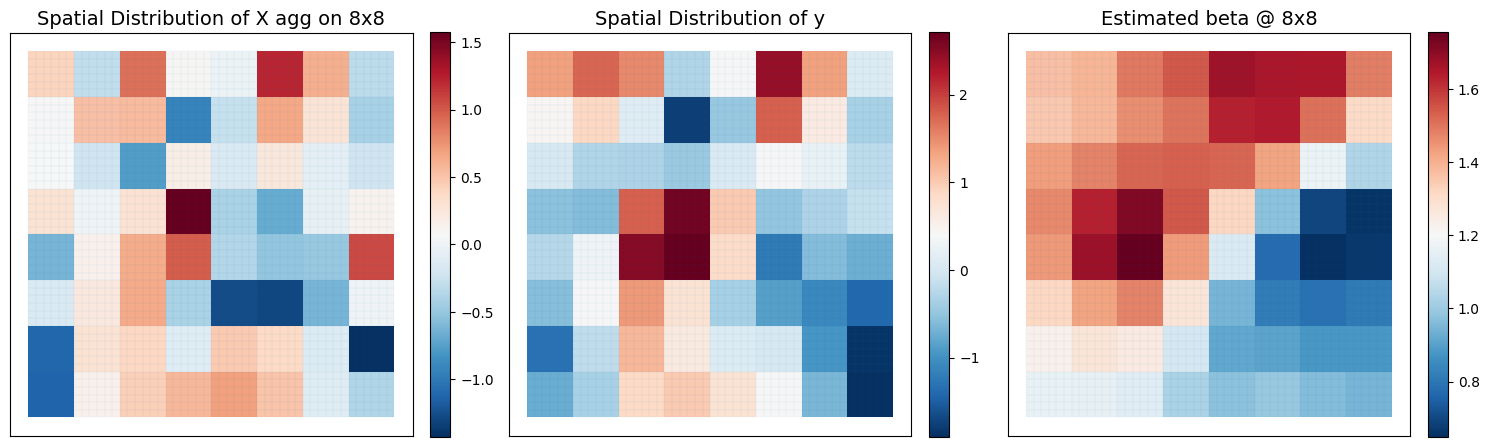

In [273]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 8x8", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta8", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 8x8", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [274]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="X_48x48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("X @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="X_24x24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("X @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="X_16x16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("X @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="X_12x12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("X @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="X_8x8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("X @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


In [275]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="y_48x48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("y @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="y_24x24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("y @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="y_16x16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("y @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="y_12x12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("y @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="y_8x8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("y @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


In [276]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="est_beta48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("beta @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="est_beta24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("beta @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="est_beta16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("beta @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="est_beta12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("beta @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="est_beta8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("beta @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


##### General VIz

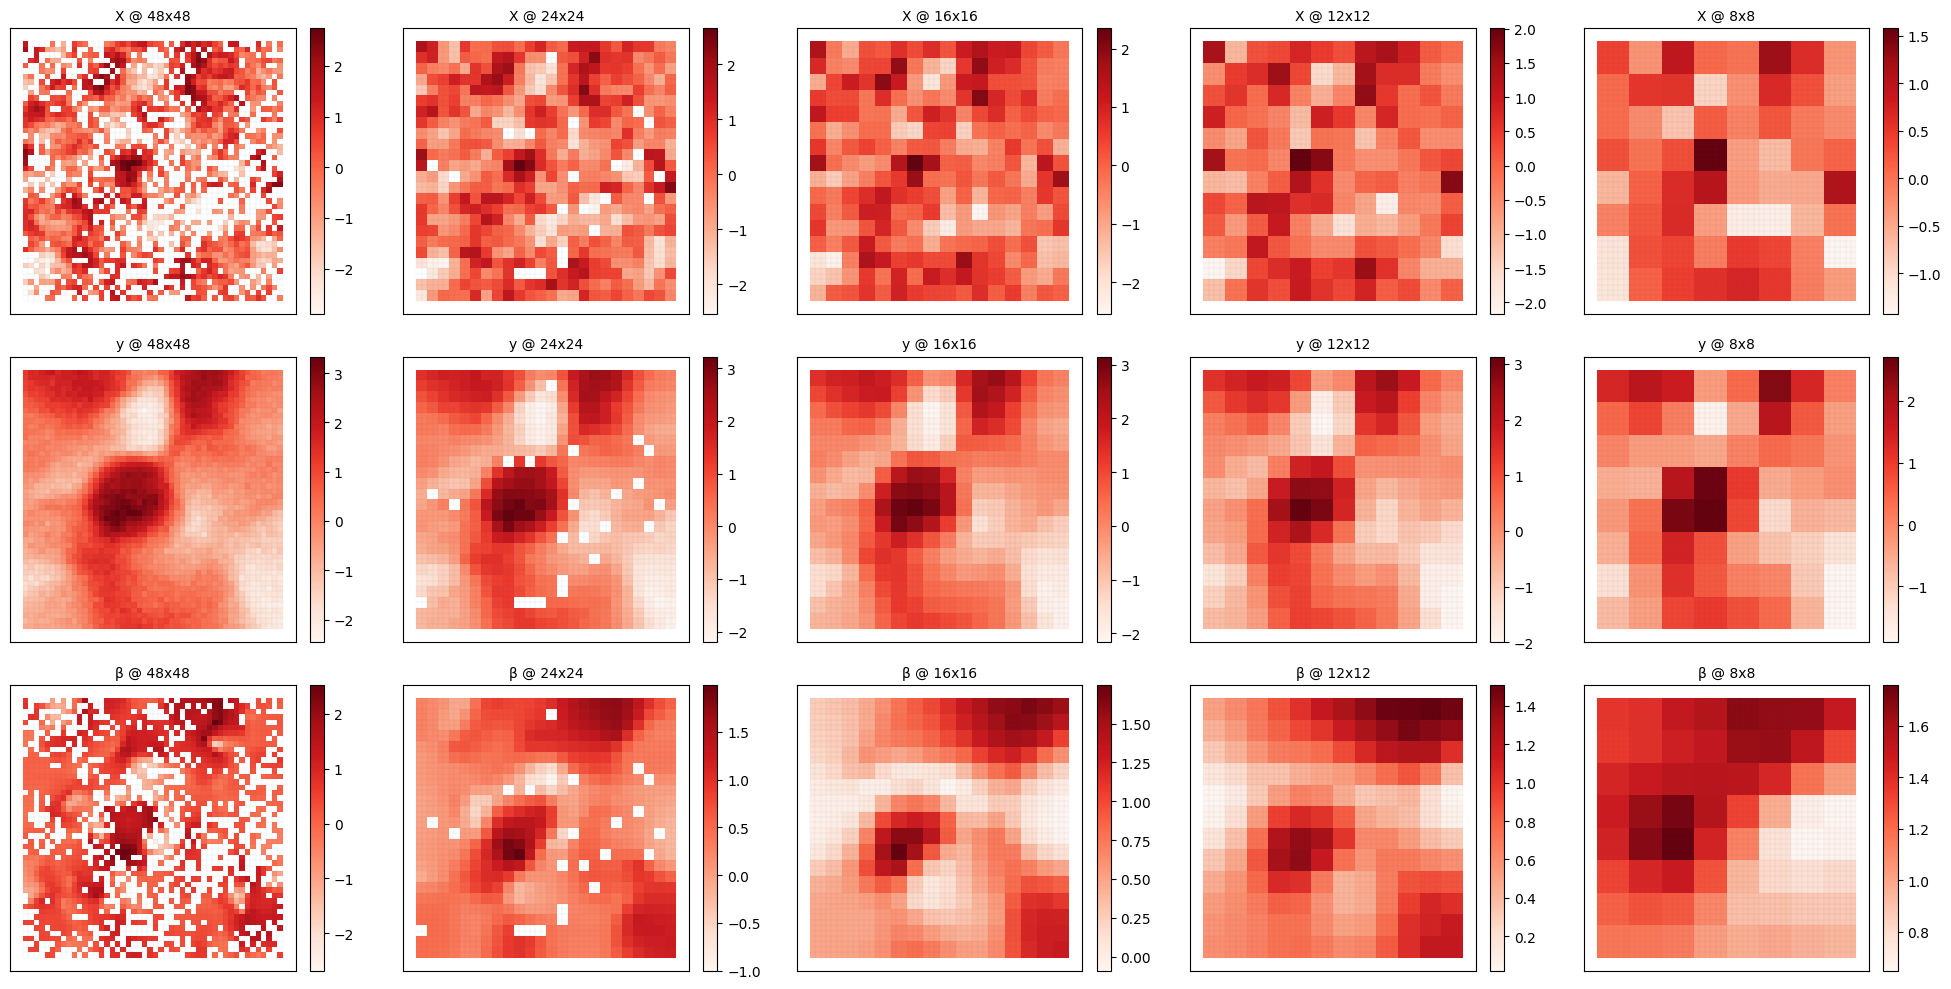

In [277]:
# Setup
res_labels = ["48x48", "24x24", "16x16", "12x12", "8x8"]
x_cols = ["X_48x48", "X_24x24", "X_16x16", "X_12x12", "X_8x8"]
y_cols = ["y_48x48", "y_24x24", "y_16x16", "y_12x12", "y_8x8"]
beta_cols = ["est_beta48", "est_beta24", "est_beta16", "est_beta12", "est_beta8"]
titles = ["X", "y", "β"]
cmap = plt.cm.Reds

# Create a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(20, 10))

# Loop through each row (X, y, β) and each column (resolutions)
for row, cols in enumerate([x_cols, y_cols, beta_cols]):
    for col, colname in enumerate(cols):
        ax = axes[row, col]
        
        # Base map (light boundary layer)
        tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax)
        
        # Choropleth plot
        tracts_gdf48.plot(column=colname, cmap=cmap, edgecolor="face", linewidth=0, ax=ax, legend=False)
        
        # Normalize for consistent colorbar
        norm = mcolors.Normalize(vmin=tracts_gdf48[colname].min(), vmax=tracts_gdf48[colname].max())
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        
        # Title and layout tweaks
        ax.set_title(f"{titles[row]} @ {res_labels[col]}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


## K = 500

In [278]:
# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts 
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

In [279]:
B = uniform_beta.flatten()

nbrs_S2 = NearestNeighbors(n_neighbors=500).fit(loc1)

smoothed_S1_to_S2 = np.zeros(len(S2))

for i in range(len(S2)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc2[i]])
    smoothed_S1_to_S2[i] = np.mean(S1[indices_S1_to_S2[0]].flatten())


np.random.seed(26)

error_term = np.random.normal(0, 0.1, len(S2))

y_orig = B * smoothed_S1_to_S2 + error_term

<Figure size 1000x800 with 0 Axes>

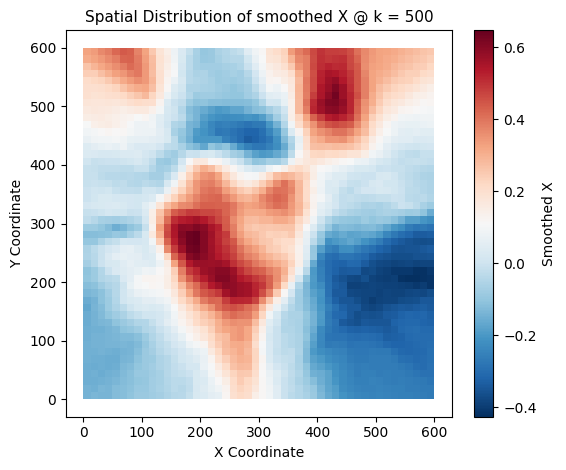

In [280]:
plt.figure(figsize=(10, 8))

# Assign smoothed values
tracts_gdf48['sX'] = smoothed_S1_to_S2

# Plot the choropleth map
ax = tracts_gdf48.plot(
    column="sX",
    cmap=plt.cm.RdBu_r,
    edgecolor="face",
    linewidth=0,
    legend=False
)

# Create scalar mappable for colorbar
norm = mcolors.Normalize(
    vmin=tracts_gdf48["sX"].min(),
    vmax=tracts_gdf48["sX"].max()
)
sm = cm.ScalarMappable(norm=norm, cmap=plt.cm.RdBu_r)
sm._A = []  # workaround to enable colorbar for ScalarMappable

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Smoothed X")

# Add labels and title
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Spatial Distribution of smoothed X @ k = 500", fontsize=11)

plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

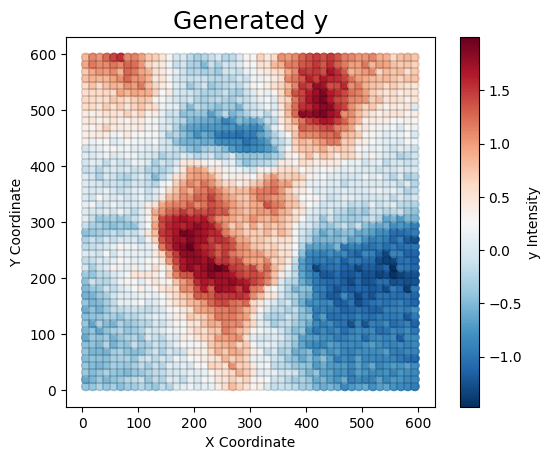

In [281]:
plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
cmap = plt.cm.RdBu_r

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=y_orig, cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Generated y", fontsize=18)

plt.show()

In [282]:
r2_list = []
srmse_list = []
bw_list = []
aicc_list = []

part1 = list(range(2, 11, 1))
part2 = list(range(15, 101, 5))
part3 = list(range(125, 1001, 25))

k_values = part1 + part2 + part3

for k in k_values:
    # --- 1. Smooth point-level X (S1) to polygon-level (S2 centroids) ---
    nbrs_S1 = NearestNeighbors(n_neighbors=k).fit(loc1)  # loc1 = point locations
    smoothed_S1_to_S2 = np.zeros(len(loc2))  # loc2 = tract centroids
    
    for i in range(len(loc2)):
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])
        bw_S1 = distances_S1_to_S2[0][-1]
        weights_X = np.exp(-0.5 * (distances_S1_to_S2[0] / bw_S1) ** 2)
        local_X = S1[indices_S1_to_S2[0]]  # S1 = point-level X
        smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)
    
    # --- 3. Fit GWR at polygon level ---
    coords = loc2  # tract centroids
    X_design = smoothed_S1_to_S2.reshape(-1,1)
    y_design = y_orig.reshape(-1,1)
    
    bw = Sel_BW(coords, y_design, X_design, constant=False).search(bw_min=2)
    gwr_model = GWR(coords, y_design, X_design, bw, constant=False)
    gwr_results = gwr_model.fit()
    
    # --- 4. Extract metrics ---
    y_pred = gwr_results.predy.flatten()
    r2 = r2_score(y_orig, y_pred)
    srmse = np.sqrt(mean_squared_error(y_orig, y_pred)) / np.std(y_orig)
    aicc = gwr_results.aicc
    
    r2_list.append(r2)
    srmse_list.append(srmse)
    bw_list.append(bw)
    aicc_list.append(aicc)
    
    print(f"k={k}: R2={r2:.4f}, SRMSE={srmse:.4f}, AICc={aicc:.4f}, BW={bw:.4f}")

k=2: R2=0.6449, SRMSE=0.5959, AICc=3653.1986, BW=20.0000
k=3: R2=0.6713, SRMSE=0.5733, AICc=3465.5131, BW=19.0000
k=4: R2=0.6879, SRMSE=0.5587, AICc=3341.5765, BW=19.0000
k=5: R2=0.6986, SRMSE=0.5490, AICc=3250.7125, BW=19.0000
k=6: R2=0.7096, SRMSE=0.5389, AICc=3158.2985, BW=19.0000
k=7: R2=0.7247, SRMSE=0.5247, AICc=3062.7113, BW=17.0000
k=8: R2=0.7259, SRMSE=0.5236, AICc=3046.5288, BW=17.0000
k=9: R2=0.7301, SRMSE=0.5195, AICc=3008.4832, BW=17.0000
k=10: R2=0.7335, SRMSE=0.5163, AICc=2980.0270, BW=16.0000
k=15: R2=0.7496, SRMSE=0.5004, AICc=2805.5634, BW=19.0000
k=20: R2=0.7736, SRMSE=0.4758, AICc=2574.4893, BW=19.0000
k=25: R2=0.7958, SRMSE=0.4518, AICc=2384.2546, BW=16.0000
k=30: R2=0.8024, SRMSE=0.4445, AICc=2280.4591, BW=19.0000
k=35: R2=0.8054, SRMSE=0.4411, AICc=2243.9201, BW=21.0000
k=40: R2=0.8080, SRMSE=0.4382, AICc=2220.1297, BW=19.0000
k=45: R2=0.8188, SRMSE=0.4257, AICc=2132.3438, BW=16.0000
k=50: R2=0.8281, SRMSE=0.4146, AICc=2017.1973, BW=16.0000
k=55: R2=0.8330, SRMSE

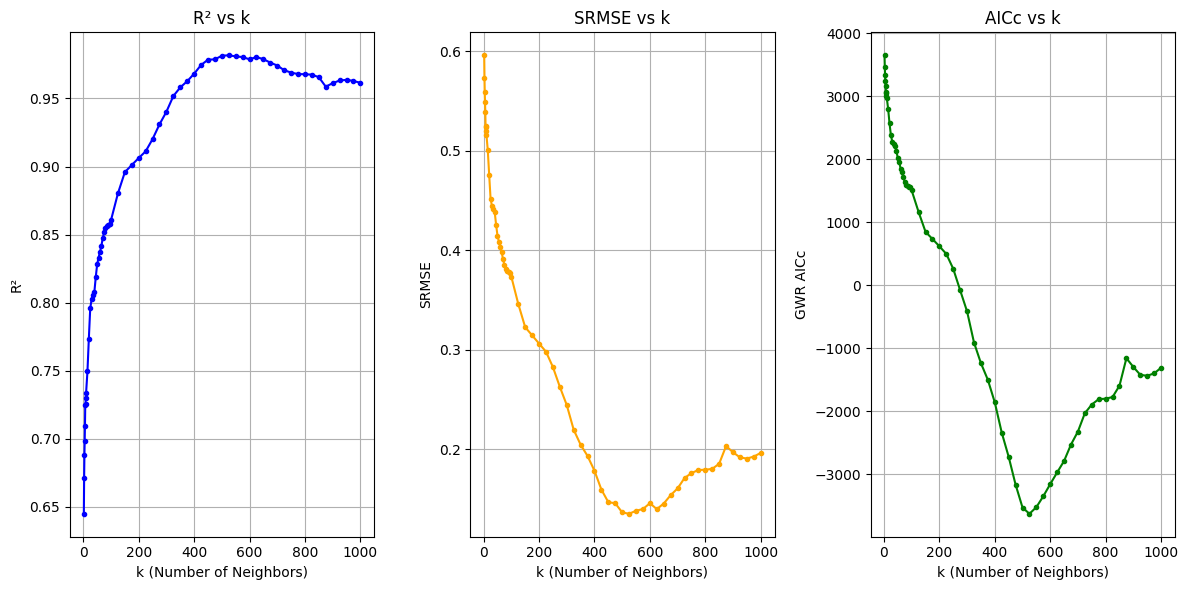

In [283]:
plt.figure(figsize=(12, 6))

# Plot R²
plt.subplot(1, 3, 1)
plt.plot(k_values, r2_list, color='blue', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R²')
plt.title('R² vs k')
plt.grid()

# Plot SRMSE
plt.subplot(1, 3, 2)
plt.plot(k_values, srmse_list, color='orange', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('SRMSE')
plt.title('SRMSE vs k')
plt.grid()


# Plot AIcc
plt.subplot(1, 3, 3)
plt.plot(k_values, aicc_list, color='green', marker='.')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('GWR AICc')
plt.title('AICc vs k')
plt.grid()

plt.tight_layout()
plt.show()

### Aggregations

#### 48x48

In [284]:
S1_gdf = gpd.GeoDataFrame({'X': S1, 'geometry': gpd.points_from_xy(loc1[:, 0], loc1[:, 1])})

In [285]:
S1_gdf

X                 geometry
0    -0.713598   POINT (32.857 197.992)
1    -0.080170  POINT (204.138 595.669)
2    -0.377087  POINT (536.507 155.182)
3     0.825593    POINT (6.775 422.464)
4     2.219904  POINT (396.912 484.592)
...        ...                      ...
3595 -1.260541   POINT (237.294 369.16)
3596  2.081240  POINT (253.043 288.905)
3597 -1.637324  POINT (342.353 125.307)
3598 -1.188416   POINT (394.937 184.82)
3599 -1.845877     POINT (5.464 75.523)

[3600 rows x 2 columns]

In [286]:
# Spatial join: assign S1 points to 48x48 tracts
S1_agg = gpd.sjoin(S1_gdf, tracts_gdf48, how="left", predicate="within")

In [287]:
S1_agg = S1_agg.groupby("tract_id")["X"].mean().reset_index()
X_48x48 = tracts_gdf48.merge(S1_agg, on="tract_id", how="left")
X_48x48['y'] = y_orig

In [288]:
sX1_48 = X_48x48.copy()
sX1_48.isna().sum()

tract_id      0
geometry      0
sX            0
X           806
y             0
dtype: int64

In [289]:
sX1_48.dropna(inplace=True)
sX1_48.isna().sum()

tract_id    0
geometry    0
sX          0
X           0
y           0
dtype: int64

In [290]:
gwr_X  = sX1_48['X'].values.reshape(-1,1)
gwr_y = sX1_48['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_48['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((1498, 1), (1498, 1))

In [291]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw48 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw48, constant=False).fit()
print(gwr_bw48)

21.0


In [292]:
params48 = gwr_results.params
y_pred48 = gwr_results.predy
aicc_gwr48 = gwr_results.aicc
r2_48 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

2618.9994438261815
0.548970113325915


In [293]:
## calculating the standardized root mean squared error
y_true48 = sX1_48['y'].values.reshape(-1,1)
rmse48  = np.sqrt(np.mean((y_true48 - y_pred48)**2))
std_dev48 = np.std(y_true48)
srmse48 = rmse48 / std_dev48
srmse48, rmse48

(np.float64(0.6715875867480613), np.float64(0.5037096406314787))

#### 24x24

In [294]:
x_step, y_step = 25, 25 # Creates a 24x24 grid, resulting in 576 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_24 = np.array([[point.x, point.y] for point in tracts_gdf24.geometry.centroid])

In [295]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [296]:
# Spatial join X to 24x24 tracts 
spj24_X = gpd.sjoin(S1_gdf, tracts_gdf24, how='right', predicate='within')
agg_24_X = spj24_X.groupby('tract_id')[['X']].mean().reset_index()

In [297]:
# Spatial join y @ 48x48 to 24x24 tracts. Extract only the y from the df: line 2. 
spj24_y = gpd.sjoin(X_48x48, tracts_gdf24, how='right', predicate='within')
agg_24_y = spj24_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [298]:
agg_24 = agg_24_X.merge(agg_24_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [299]:
# Aggregate X & Y within each 24x24 grid cell
GWR_24x24_gdf = tracts_gdf24.merge(agg_24, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [300]:
sX1_24 = GWR_24x24_gdf.copy()
sX1_24.isna().sum()

tract_id           0
geometry           0
X                 23
tract_id_right     0
y                  0
dtype: int64

In [301]:
sX1_24.dropna(inplace=True)
sX1_24.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [302]:
gwr_X  = sX1_24['X'].values.reshape(-1,1)
gwr_y = sX1_24['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_24['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((553, 1), (553, 1))

In [303]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw24 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw24, constant=False).fit()
print(gwr_bw24)

21.0


In [304]:
params24 = gwr_results.params
y_pred24 = gwr_results.predy
aicc_gwr24 = gwr_results.aicc
r2_24 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

1077.447054996851
0.4456832447746124


In [305]:
## calculating the standardized root mean squared error
y_true24 = sX1_24['y'].values.reshape(-1,1)
rmse24  = np.sqrt(np.mean((y_true24 - y_pred24)**2))
std_dev24 = np.std(y_true24)
srmse24 = rmse24 / std_dev24
srmse24, rmse24

(np.float64(0.7445245162017081), np.float64(0.5525000923067961))

#### 16x16

In [306]:
x_step, y_step = 37.5, 37.5 # Creates a 32x32 grid, resulting in 576 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_16 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])

In [307]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [308]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [309]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [310]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [311]:
# Aggregate X & y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [312]:
sX1_16 = GWR_16x16_gdf.copy()

gwr_X  = sX1_16['X'].values.reshape(-1,1)
gwr_y = sX1_16['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_16['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [313]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw16 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw16, constant=False).fit()
print(gwr_bw16)

23.0


In [314]:
params16 = gwr_results.params
y_pred16 = gwr_results.predy
aicc_gwr16 = gwr_results.aicc
r2_16 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

508.2348992020499
0.3706571860393293


In [315]:
## calculating the standardized root mean squared error
y_true16 = sX1_16['y'].values.reshape(-1,1)
rmse16  = np.sqrt(np.mean((y_true16 - y_pred16)**2))
std_dev16 = np.std(y_true16)
srmse16 = rmse16 / std_dev16
srmse16, rmse16

(np.float64(0.793311297008098), np.float64(0.5797553418000007))

#### 12x12

In [316]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 50, 50  # Creates a 12x12 grid, resulting in 144 tracts cell divisions
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_12 = np.array([[point.x, point.y] for point in tracts_gdf12.geometry.centroid])

In [317]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [318]:
# Spatial join X to 12x12 tracts 
spj12_X = gpd.sjoin(S1_gdf, tracts_gdf12, how='right', predicate='within')
agg_12_X = spj12_X.groupby('tract_id')[['X']].mean().reset_index()

In [319]:
# Spatial join y @ 48x48 to 12x12 tracts. Extract only the y from the df: line 2. 
spj12_y = gpd.sjoin(X_48x48, tracts_gdf12, how='right', predicate='within')
agg_12_y = spj12_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [320]:
agg_12 = agg_12_X.merge(agg_12_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [321]:
# Aggregate X & Y within each 24x24 grid cell
GWR_12x12_gdf = tracts_gdf12.merge(agg_12, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [322]:
sX1_12 = GWR_12x12_gdf.copy()
sX1_12.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [323]:
gwr_X  = sX1_12['X'].values.reshape(-1,1)
gwr_y = sX1_12['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_12['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((144, 1), (144, 1))

In [324]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw12 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw12, constant=False).fit()
print(gwr_bw12)

21.0


In [325]:
params12 = gwr_results.params
y_pred12 = gwr_results.predy
aicc_gwr12 = gwr_results.aicc
r2_12 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

292.77651890796255
0.3829800017981232


In [326]:
## calculating the standardized root mean squared error
y_true12 = sX1_12['y'].values.reshape(-1,1)
rmse12  = np.sqrt(np.mean((y_true12 - y_pred12)**2))
std_dev12 = np.std(y_true12)
srmse12 = rmse12 / std_dev12
srmse12, rmse12

(np.float64(0.7855062050689838), np.float64(0.566024315605272))

##### 8x8

In [327]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 8x8 grid, resulting in 256 tracts cell divisions
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

loc2_8 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])

In [328]:
X_48x48['geometry'] = X_48x48.geometry.centroid

In [329]:
# Spatial join X to 8x8 tracts 
spj8_X = gpd.sjoin(S1_gdf, tracts_gdf8, how='right', predicate='within')
agg_8_X = spj8_X.groupby('tract_id')[['X']].mean().reset_index()

In [330]:
# Spatial join y @ 48x48 to 8x8 tracts. Extract only the y from the df: line 2. 
spj8_y = gpd.sjoin(X_48x48, tracts_gdf8, how='right', predicate='within')
agg_8_y = spj8_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [331]:
agg_8 = agg_8_X.merge(agg_8_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [332]:
# Aggregate X & Y within each 24x24 grid cell
GWR_8x8_gdf = tracts_gdf8.merge(agg_8, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

In [333]:
sX1_8 = GWR_8x8_gdf.copy()
sX1_8.isna().sum()

tract_id          0
geometry          0
X                 0
tract_id_right    0
y                 0
dtype: int64

In [334]:
gwr_X  = sX1_8['X'].values.reshape(-1,1)
gwr_y = sX1_8['y'].values.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1_8['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [335]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw8 = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw8, constant=False).fit()
print(gwr_bw8)

24.0


In [336]:
params8 = gwr_results.params
y_pred8 = gwr_results.predy
aicc_gwr8 = gwr_results.aicc
r2_8 = gwr_results.R2

print(gwr_results.aicc), print(gwr_results.R2);

133.91001994619438
0.257395399845613


In [337]:
## calculating the standardized root mean squared error
y_true8 = sX1_8['y'].values.reshape(-1,1)
rmse8  = np.sqrt(np.mean((y_true8 - y_pred8)**2))
std_dev8 = np.std(y_true8)
srmse8 = rmse8 / std_dev8
srmse8, rmse8

(np.float64(0.861745090008865), np.float64(0.6033159277505524))

#### table

In [338]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [339]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [340]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [341]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24    16x16    12x12      8x8
BW         21.0000  21.0000  23.0000  21.0000  24.0000
R²          0.5490   0.4457   0.3707   0.3830   0.2574
SRMSE       0.6716   0.7445   0.7933   0.7855   0.8617

##### table

In [342]:
grid_sizes = [s for s in ['48x48', '24x24', '16x16', '12x12', '8x8'] for _ in range(3)] 
metrics = ['R²', 'SRMSE', 'BW'] * 5  # Repeat R² and SRMSE for each grid size
# values = [r2_48, srmse48, r2_40, srmse40, r2_32, srmse32, r2_24, srmse24, r2_16, srmse16, r2_8, srmse8]
r2 = [r2_48, r2_24, r2_16, r2_12, r2_8]
srmse = [ srmse48, srmse24, srmse16,srmse12, srmse8]
bw = [gwr_bw48, gwr_bw24, gwr_bw16, gwr_bw12, gwr_bw8]

values = []
for i in range(5):
    values.extend([r2[i], srmse[i], bw[i]])

In [343]:
len(metrics), len(grid_sizes), len(values)


(15, 15, 15)

In [344]:
df = pd.DataFrame({
    'Metric': metrics, # Repeat each grid size for R², SRMSE, BW,
    'Grid Size': grid_sizes,
    'Value': np.round(values, 4)
})

In [345]:
# Reset index to start from 1
df.index = range(1, len(df) + 1)

# Pivot the table to get desired format
df_pivot = df.pivot(index='Metric', columns='Grid Size', values='Value')

df_pivot = df_pivot.reindex(columns=['48x48', '24x24', '16x16', '12x12', '8x8'])
# Remove the "Metric" label
df_pivot.index.name = None
df_pivot

Grid Size    48x48    24x24    16x16    12x12      8x8
BW         21.0000  21.0000  23.0000  21.0000  24.0000
R²          0.5490   0.4457   0.3707   0.3830   0.2574
SRMSE       0.6716   0.7445   0.7933   0.7855   0.8617

#### Visualizations

##### 48x48

In [346]:
loc2_48 = np.array([[point.x, point.y] for point in sX1_48.geometry.centroid])

In [347]:
sX1_48['params48'] = params48
sX1_48

tracts_gdf48_points = tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj48_48 = gpd.sjoin(tracts_gdf48_points, sX1_48, how='left', predicate='within')
spj48_48['y'] = y_orig

tracts_gdf48["X_48x48"] = spj48_48["X"]
tracts_gdf48['y_48x48'] = spj48_48["y"]
tracts_gdf48['est_beta48'] = spj48_48["params48"]


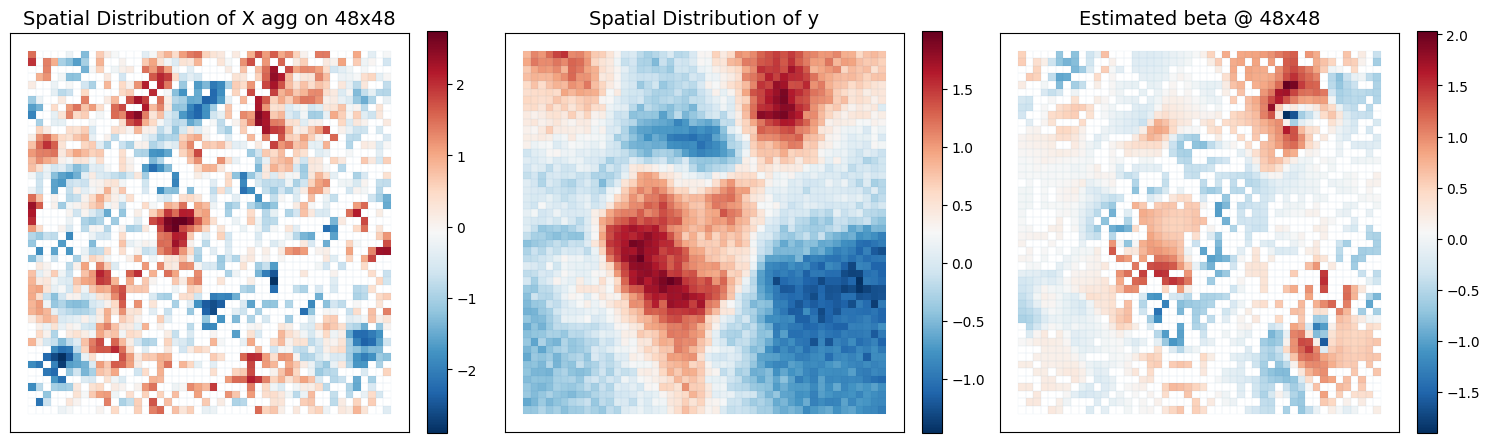

In [348]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 48x48", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_48x48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_48x48", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta48
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta48", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 48x48", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 24x24

In [349]:
sX1_24['params24'] = params24
sX1_24

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj24_48 = gpd.sjoin(tracts_gdf48_points, sX1_24, how='left', predicate='within')

In [350]:
tracts_gdf48["X_24x24"] = spj24_48["X"]
tracts_gdf48['y_24x24'] = spj24_48["y"]
tracts_gdf48['est_beta24'] = spj24_48["params24"]

In [351]:
spj24_48["X"]

0      -2.137928
1      -2.137928
2      -1.336631
3      -1.336631
4            NaN
          ...   
2299   -0.809597
2300   -0.156722
2301   -0.156722
2302   -0.349581
2303   -0.349581
Name: X, Length: 2304, dtype: float64

In [352]:
tracts_gdf48['est_beta24'].isna().sum()

np.int64(92)

In [353]:
# Spatial join X to 16x16 tracts 
spj16_X = gpd.sjoin(S1_gdf, tracts_gdf16, how='right', predicate='within')
agg_16_X = spj16_X.groupby('tract_id')[['X']].mean().reset_index()

In [354]:
# Spatial join y @ 48x48 to 16x16 tracts. Extract only the y from the df: line 2. 
spj16_y = gpd.sjoin(X_48x48, tracts_gdf16, how='right', predicate='within')
agg_16_y = spj16_y.groupby('tract_id_right')[['y']].mean().reset_index()

In [355]:
agg_16 = agg_16_X.merge(agg_16_y, left_on='tract_id', right_on='tract_id_right').drop('tract_id', axis=1)

In [356]:
# Aggregate X & Y within each 24x24 grid cell
GWR_16x16_gdf = tracts_gdf16.merge(agg_16, left_index=True, right_on='tract_id_right', how='left').reset_index(drop=True)

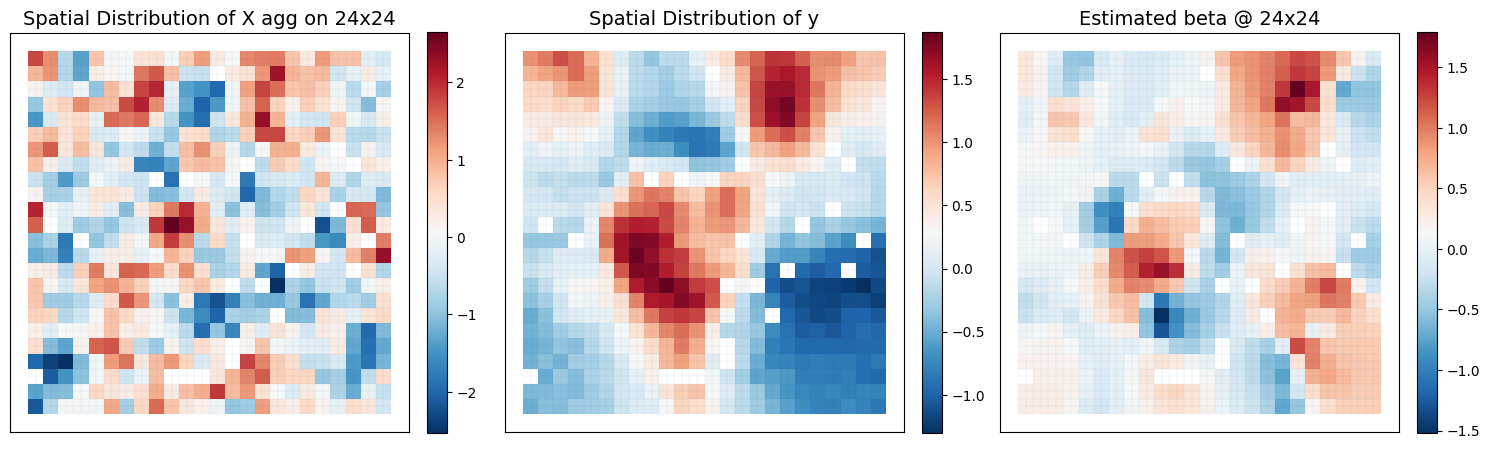

In [357]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 24x24", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_24x24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_24x24", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta24
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta24", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 24x24", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 16x16

In [358]:
sX1_16['params16'] = params16
sX1_16

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj16_48 = gpd.sjoin(tracts_gdf48_points, sX1_16, how='left', predicate='within')

In [359]:
tracts_gdf48["X_16x16"] = spj16_48["X"]
tracts_gdf48['y_16x16'] = spj16_48["y"]
tracts_gdf48['est_beta16'] = spj16_48["params16"]

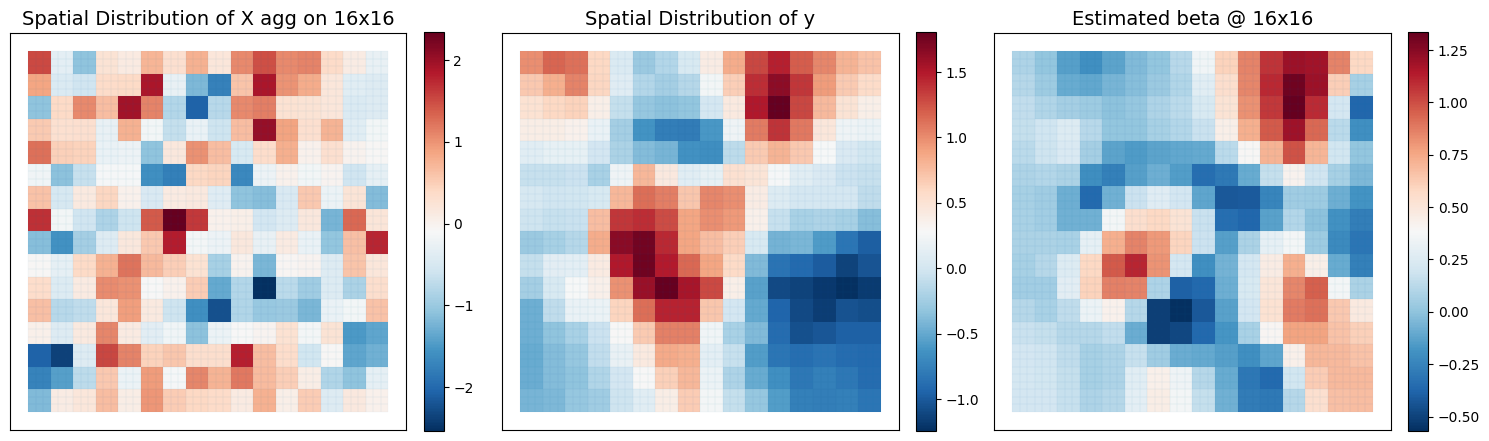

In [360]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 16x16", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_16x16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_16x16", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta16
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta16", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 16x16", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 12x12

In [361]:
sX1_12['params12'] = params12
sX1_12

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj12_48 = gpd.sjoin(tracts_gdf48_points, sX1_12, how='left', predicate='within')

In [362]:
tracts_gdf48["X_12x12"] = spj12_48["X"]
tracts_gdf48['y_12x12'] = spj12_48["y"]
tracts_gdf48['est_beta12'] = spj12_48["params12"]

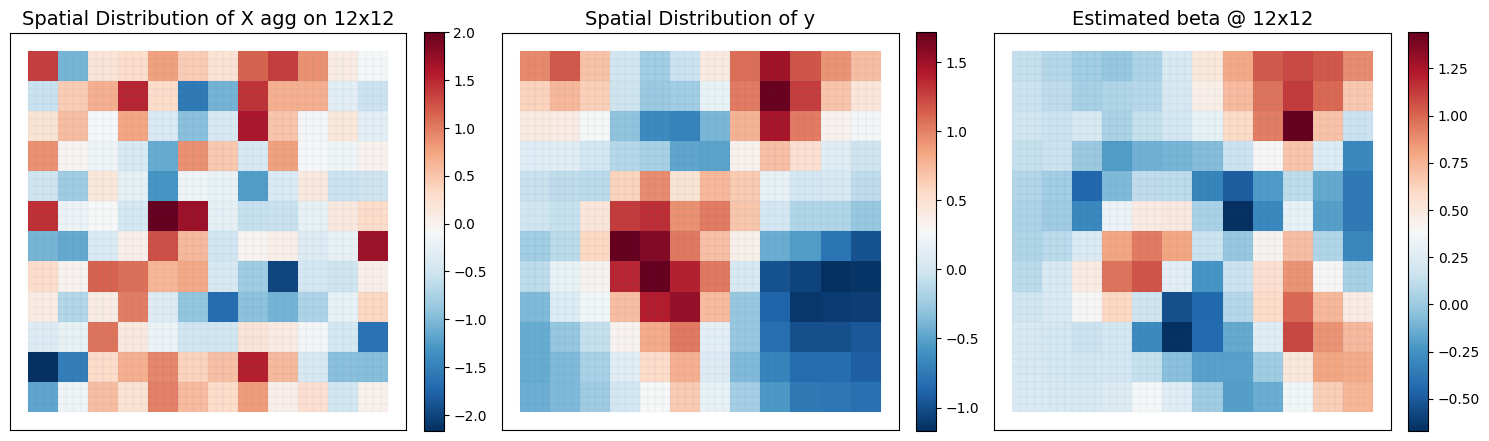

In [363]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 12x12", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_12x12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_12x12", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta12
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta12", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 12x12", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


##### 8x8

In [364]:
sX1_8['params8'] = params8

tracts_gdf48_points = orig_tracts_gdf48.copy()
tracts_gdf48_points['geometry'] = tracts_gdf48_points['geometry'].centroid
spj8_48 = gpd.sjoin(tracts_gdf48_points, sX1_8, how='left', predicate='within')

In [365]:
tracts_gdf48["X_8x8"] = spj8_48["X"]
tracts_gdf48['y_8x8'] = spj8_48["y"]
tracts_gdf48['est_beta8'] = spj8_48["params8"]

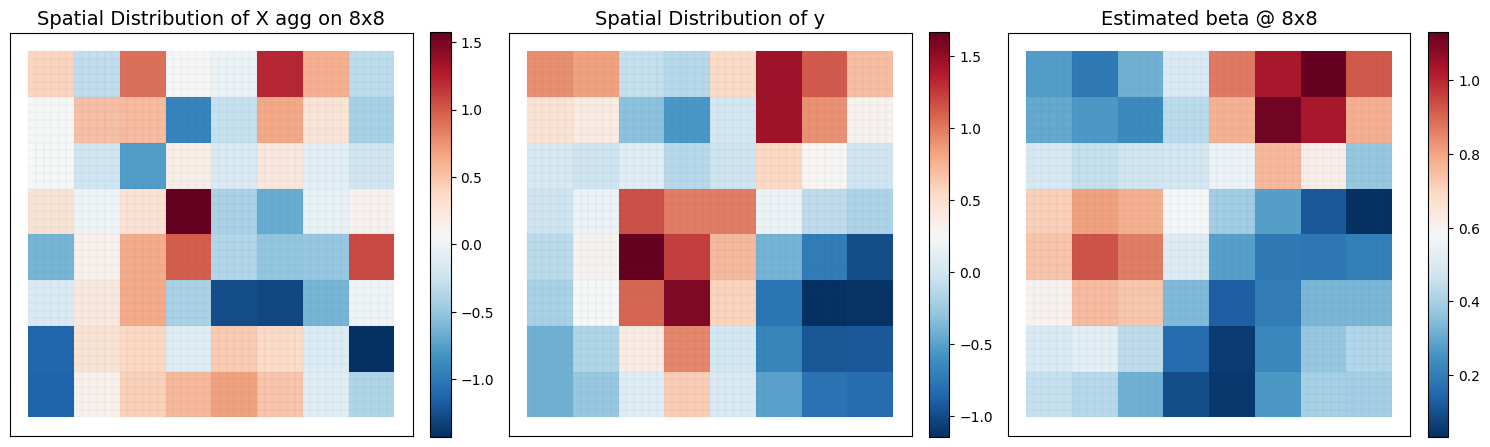

In [366]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap1 = plt.cm.Reds
cmap2 = plt.cm.RdBu_r
cmap3 = plt.cm.RdBu_r

# Plot 1 - X_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
plot1 = tracts_gdf48.plot(column="X_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[0], legend=False)
ax[0].set_title("Spatial Distribution of X agg on 8x8", fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Colorbar for Plot 1
norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
sm1 = cm.ScalarMappable(cmap=cmap2, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# Plot 2 - y_8x8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
plot2 = tracts_gdf48.plot(column="y_8x8", cmap=cmap2,
                          edgecolor="face", linewidth=0,
                          ax=ax[1], legend=False)
ax[1].set_title("Spatial Distribution of y", fontsize=14)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Colorbar for Plot 2
norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# Plot 3 - est_beta8
tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
plot3 = tracts_gdf48.plot(column="est_beta8", cmap=cmap3,
                          edgecolor="face", linewidth=0,
                          ax=ax[2], legend=False)
ax[2].set_title("Estimated beta @ 8x8", fontsize=14)
ax[2].set_xticks([])
ax[2].set_yticks([])

# Colorbar for Plot 3
norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
sm3 = cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_array([])
fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [367]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="X_48x48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("X @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["X_48x48"].min(), vmax=tracts_gdf48["X_48x48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="X_24x24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("X @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["X_24x24"].min(), vmax=tracts_gdf48["X_24x24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="X_16x16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("X @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["X_16x16"].min(), vmax=tracts_gdf48["X_16x16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="X_12x12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("X @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["X_12x12"].min(), vmax=tracts_gdf48["X_12x12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="X_8x8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("X @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["X_8x8"].min(), vmax=tracts_gdf48["X_8x8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


In [368]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="y_48x48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("y @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["y_48x48"].min(), vmax=tracts_gdf48["y_48x48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="y_24x24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("y @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["y_24x24"].min(), vmax=tracts_gdf48["y_24x24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="y_16x16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("y @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["y_16x16"].min(), vmax=tracts_gdf48["y_16x16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="y_12x12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("y @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["y_12x12"].min(), vmax=tracts_gdf48["y_12x12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="y_8x8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("y @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["y_8x8"].min(), vmax=tracts_gdf48["y_8x8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


In [369]:
# fig, ax = plt.subplots(1, 5, figsize=(20, 4))
# cmap = plt.cm.RdBu_r  # use the same diverging colormap

# # === Plot 1: X @ 48x48 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[0])
# tracts_gdf48.plot(column="est_beta48", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[0], legend=False)
# ax[0].set_title("beta @ 48x48", fontsize=10)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# norm1 = mcolors.Normalize(vmin=tracts_gdf48["est_beta48"].min(), vmax=tracts_gdf48["est_beta48"].max())
# sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
# sm1.set_array([])
# fig.colorbar(sm1, ax=ax[0], fraction=0.046, pad=0.04)

# # === Plot 2: X @ 24x24 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[1])
# tracts_gdf48.plot(column="est_beta24", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[1], legend=False)
# ax[1].set_title("beta @ 24x24", fontsize=10)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# norm2 = mcolors.Normalize(vmin=tracts_gdf48["est_beta24"].min(), vmax=tracts_gdf48["est_beta24"].max())
# sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
# sm2.set_array([])
# fig.colorbar(sm2, ax=ax[1], fraction=0.046, pad=0.04)

# # === Plot 3: X @ 16x16 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[2])
# tracts_gdf48.plot(column="est_beta16", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[2], legend=False)
# ax[2].set_title("beta @ 16x16", fontsize=10)
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# norm3 = mcolors.Normalize(vmin=tracts_gdf48["est_beta16"].min(), vmax=tracts_gdf48["est_beta16"].max())
# sm3 = cm.ScalarMappable(cmap=cmap, norm=norm3)
# sm3.set_array([])
# fig.colorbar(sm3, ax=ax[2], fraction=0.046, pad=0.04)

# # === Plot 4: X @ 12x12 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[3])
# tracts_gdf48.plot(column="est_beta12", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[3], legend=False)
# ax[3].set_title("beta @ 12x12", fontsize=10)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# norm4 = mcolors.Normalize(vmin=tracts_gdf48["est_beta12"].min(), vmax=tracts_gdf48["est_beta12"].max())
# sm4 = cm.ScalarMappable(cmap=cmap, norm=norm4)
# sm4.set_array([])
# fig.colorbar(sm4, ax=ax[3], fraction=0.046, pad=0.04)

# # === Plot 5: X @ 8x8 ===
# tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax[4])
# tracts_gdf48.plot(column="est_beta8", cmap=cmap, edgecolor="face", linewidth=0, ax=ax[4], legend=False)
# ax[4].set_title("beta @ 8x8", fontsize=10)
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# norm5 = mcolors.Normalize(vmin=tracts_gdf48["est_beta8"].min(), vmax=tracts_gdf48["est_beta8"].max())
# sm5 = cm.ScalarMappable(cmap=cmap, norm=norm5)
# sm5.set_array([])
# fig.colorbar(sm5, ax=ax[4], fraction=0.046, pad=0.04)

# plt.tight_layout()


##### general visualization

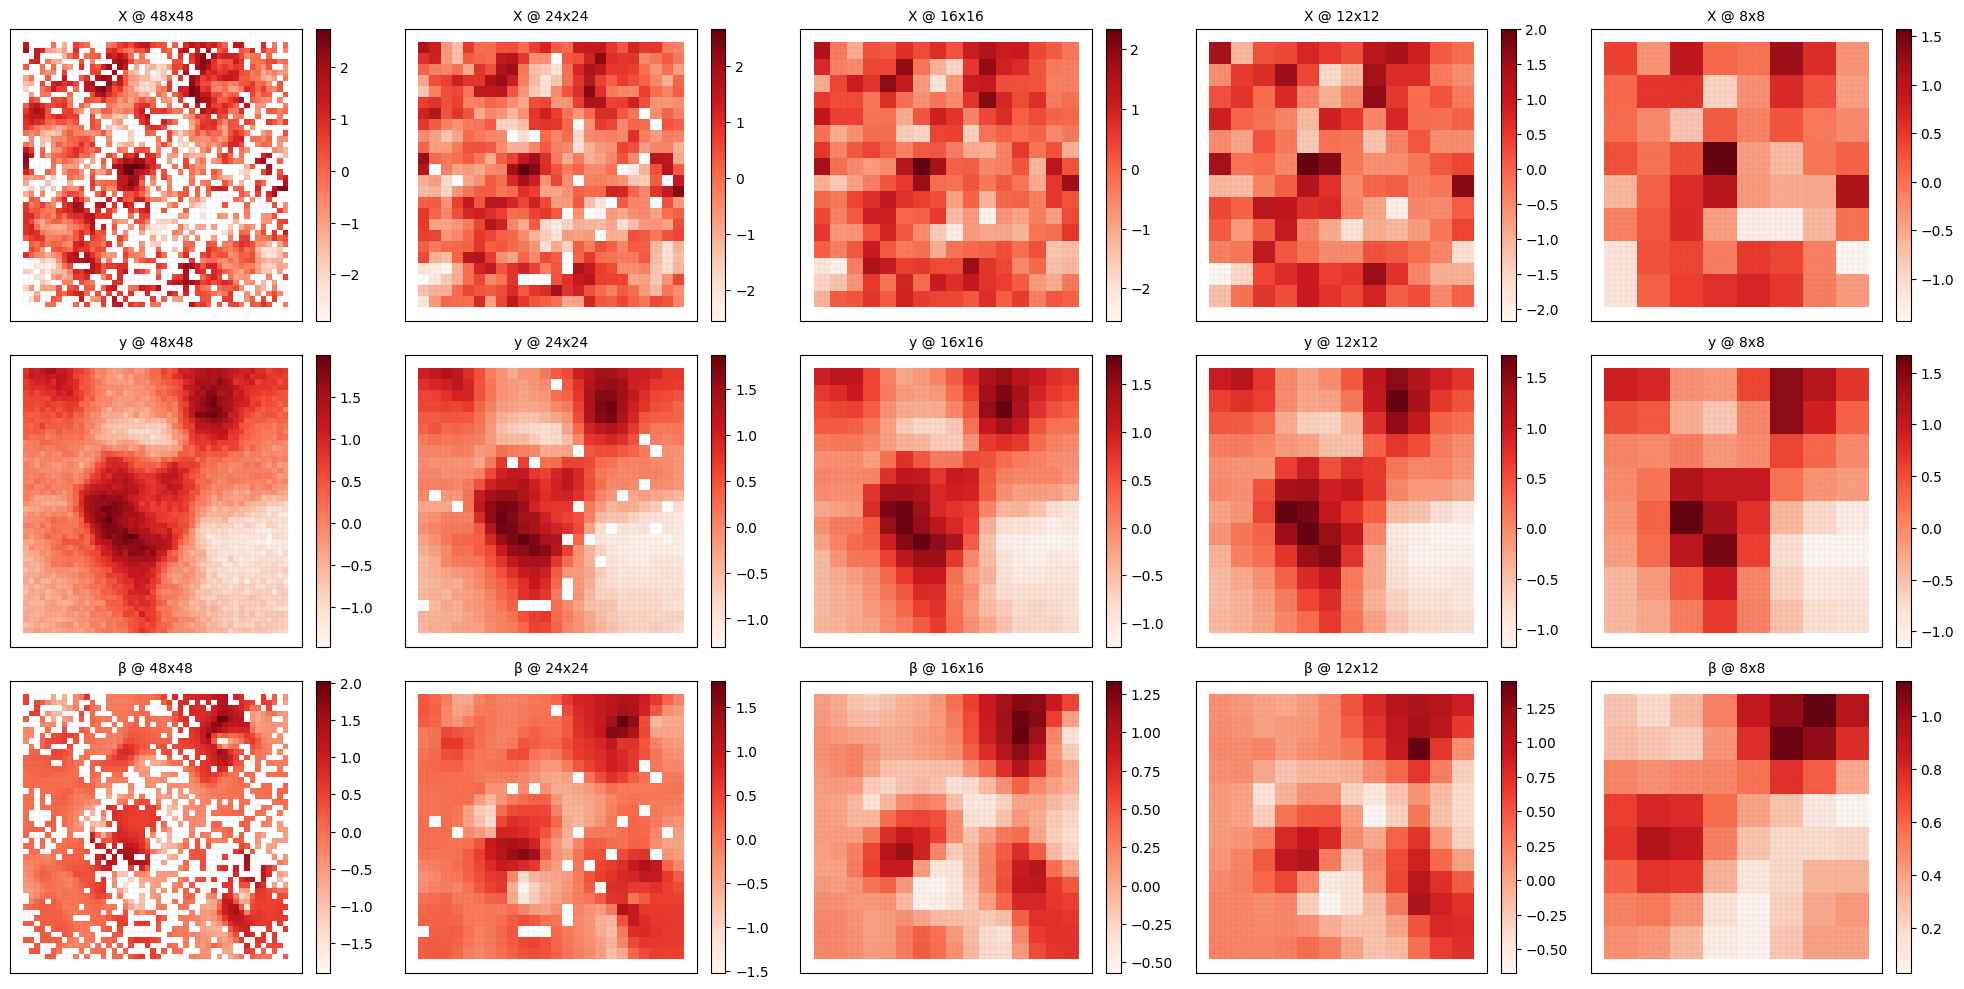

In [370]:
# Setup
res_labels = ["48x48", "24x24", "16x16", "12x12", "8x8"]
x_cols = ["X_48x48", "X_24x24", "X_16x16", "X_12x12", "X_8x8"]
y_cols = ["y_48x48", "y_24x24", "y_16x16", "y_12x12", "y_8x8"]
beta_cols = ["est_beta48", "est_beta24", "est_beta16", "est_beta12", "est_beta8"]
titles = ["X", "y", "β"]
cmap = plt.cm.Reds

# Create a 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(20, 10))

# Loop through each row (X, y, β) and each column (resolutions)
for row, cols in enumerate([x_cols, y_cols, beta_cols]):
    for col, colname in enumerate(cols):
        ax = axes[row, col]
        
        # Base map (light boundary layer)
        tracts_gdf48.boundary.plot(edgecolor=None, linewidth=0.1, alpha=0.2, ax=ax)
        
        # Choropleth plot
        tracts_gdf48.plot(column=colname, cmap=cmap, edgecolor="face", linewidth=0, ax=ax, legend=False)
        
        # Normalize for consistent colorbar
        norm = mcolors.Normalize(vmin=tracts_gdf48[colname].min(), vmax=tracts_gdf48[colname].max())
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        
        # Title and layout tweaks
        ax.set_title(f"{titles[row]} @ {res_labels[col]}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


##### 